In [1]:
# !pip install kmodes

In [2]:
# import key libraries
import pyreadstat
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn as sk

# other libraries
import missingno as msno
from math import ceil
from regressors import stats
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings("ignore")

In [3]:
# load SAS file
og_df, meta = pyreadstat.read_sas7bdat('a2z_insurance.sas7bdat')

In [4]:
df = og_df.copy()

# **Dataset exploration**

In [5]:
# data types
df.dtypes

CustID           float64
FirstPolYear     float64
BirthYear        float64
EducDeg           object
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

In [6]:
# data description
df.describe(include = "all").T

count unique          top  freq         mean          std  \
CustID         10296.0    NaN          NaN   NaN       5148.5   2972.34352   
FirstPolYear   10266.0    NaN          NaN   NaN  1991.062634   511.267913   
BirthYear      10279.0    NaN          NaN   NaN  1968.007783    19.709476   
EducDeg          10296      5  3 - BSc/MSc  4799          NaN          NaN   
MonthSal       10260.0    NaN          NaN   NaN  2506.667057  1157.449634   
GeoLivArea     10295.0    NaN          NaN   NaN     2.709859     1.266291   
Children       10275.0    NaN          NaN   NaN     0.706764     0.455268   
CustMonVal     10296.0    NaN          NaN   NaN   177.892605  1945.811505   
ClaimsRate     10296.0    NaN          NaN   NaN     0.742772     2.916964   
PremMotor      10262.0    NaN          NaN   NaN   300.470252   211.914997   
PremHousehold  10296.0    NaN          NaN   NaN   210.431192   352.595984   
PremHealth     10253.0    NaN          NaN   NaN   171.580833   296.405976   
PremLife       10192.0    NaN          NaN   NaN    41.855782    47.480632   
PremWork       10210.0    NaN          NaN   NaN    41.277514    51.513572   

                     min      25%     50%       75%       max  
CustID               1.0  2574.75  5148.5   7722.25   10296.0  
FirstPolYear      1974.0   1980.0  1986.0    1992.0   53784.0  
BirthYear         1028.0   1953.0  1968.0    1983.0    2001.0  
EducDeg              NaN      NaN     NaN       NaN       NaN  
MonthSal           333.0   1706.0  2501.5   3290.25   55215.0  
GeoLivArea           1.0      1.0     3.0       4.0       4.0  
Children             0.0      0.0     1.0       1.0       1.0  
CustMonVal    -165680.42    -9.44  186.87  399.7775  11875.89  
ClaimsRate           0.0     0.39    0.72      0.98     256.2  
PremMotor          -4.11   190.59  298.61     408.3  11604.42  
PremHousehold      -75.0    49.45   132.8    290.05   25048.8  
PremHealth         -2.11    111.8  162.81    219.82   28272.0  
PremLife            -7.0     9.89   25.56     57.79     398.3  
PremWork           -12.0    10.67   25.67     56.79    1988.7

In [7]:
# take a look at the data
df.head(10)

CustID  FirstPolYear  BirthYear          EducDeg  MonthSal  GeoLivArea  \
0     1.0        1985.0     1982.0  2 - High School    2177.0         1.0   
1     2.0        1981.0     1995.0  2 - High School     677.0         4.0   
2     3.0        1991.0     1970.0        1 - Basic    2277.0         3.0   
3     4.0        1990.0     1981.0      3 - BSc/MSc    1099.0         4.0   
4     5.0        1986.0     1973.0      3 - BSc/MSc    1763.0         4.0   
5     6.0        1986.0     1956.0  2 - High School    2566.0         4.0   
6     7.0        1979.0     1943.0  2 - High School    4103.0         4.0   
7     8.0        1988.0     1974.0  2 - High School    1743.0         4.0   
8     9.0        1981.0     1978.0      3 - BSc/MSc    1862.0         1.0   
9    10.0        1976.0     1948.0      3 - BSc/MSc    3842.0         1.0   

   Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0       1.0      380.97        0.39     375.85          79.45      146.36   
1       1.0     -131.13        1.12      77.46         416.20      116.69   
2       0.0      504.67        0.28     206.15         224.50      124.58   
3       1.0      -16.99        0.99     182.48          43.35      311.17   
4       1.0       35.23        0.90     338.62          47.80      182.59   
5       1.0      -24.33        1.00     440.75          18.90      114.80   
6       0.0      -66.01        1.05     156.92         295.60      317.95   
7       1.0     -144.91        1.13     248.27         397.30      144.36   
8       1.0      356.53        0.36     344.51          18.35      210.04   
9       0.0     -119.35        1.12     209.26         182.25      271.94   

   PremLife  PremWork  
0     47.01     16.89  
1    194.48    106.13  
2     86.35     99.02  
3     35.34     28.34  
4     18.78     41.45  
5      7.00      7.67  
6     14.67     26.34  
7     66.68     53.23  
8      8.78      9.89  
9     39.23     55.12

In [8]:
# set customer ID as index
df.CustID = df.CustID.astype("int")
df.set_index("CustID", inplace=True)

In [9]:
# check data types
df.dtypes

FirstPolYear     float64
BirthYear        float64
EducDeg           object
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

In [10]:
# check for duplicated observations
print("Number of duplicate observations:", df.duplicated().sum())

# remove duplicate observations
df.drop_duplicates(inplace = True)
print("Removing duplicates...")
print("Number of duplicate observations:", df.duplicated().sum())

Number of duplicate observations: 3
Removing duplicates...
Number of duplicate observations: 0


In [11]:
# starting number of observations after duplicate removal
print(len(df))

10293


# **Cleaning up the dataset**

## Changing data types

In [12]:
# changing data types
# extract only number from EducDeg and save as float (ordinal variable)
# empty strings converted to NaN
# could also use sklearn's LabelEncoder??????????
df.EducDeg = df.EducDeg.str.extract("(\d+)")
# EducDeg is actually ordinal but stored as categorical for now
df.EducDeg = df.EducDeg.astype("category")

# convert other features to categorical
df.GeoLivArea = df.GeoLivArea.astype("category")
df.Children = df.Children.astype("category")

# check if changes were successful
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10293 entries, 1 to 10296
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   FirstPolYear   10263 non-null  float64 
 1   BirthYear      10276 non-null  float64 
 2   EducDeg        10276 non-null  category
 3   MonthSal       10257 non-null  float64 
 4   GeoLivArea     10292 non-null  category
 5   Children       10272 non-null  category
 6   CustMonVal     10293 non-null  float64 
 7   ClaimsRate     10293 non-null  float64 
 8   PremMotor      10259 non-null  float64 
 9   PremHousehold  10293 non-null  float64 
 10  PremHealth     10250 non-null  float64 
 11  PremLife       10189 non-null  float64 
 12  PremWork       10207 non-null  float64 
dtypes: category(3), float64(10)
memory usage: 915.2 KB


## Cross-field validation

In [13]:
# 1997 rows where birth year is after the first policy year
df[df.BirthYear > df.FirstPolYear]

# high number of inconsistencies indicates systematic error
# assumption: people introduce the years in the wrong fields and many FirstPolYear and BirthYear are swapped
# swap FirstPolYear and BirthYear values when birth is after first policy creation
row_selector = df.BirthYear > df.FirstPolYear
df.loc[row_selector, ["FirstPolYear", "BirthYear"]] = df.loc[row_selector, ["BirthYear", "FirstPolYear"]].values

## Dealing with outliers

In [14]:
# define metric and non-metric features
metric_features = df.select_dtypes(include = np.number).columns.tolist()
non_metric_features = df.columns.drop(metric_features).tolist()

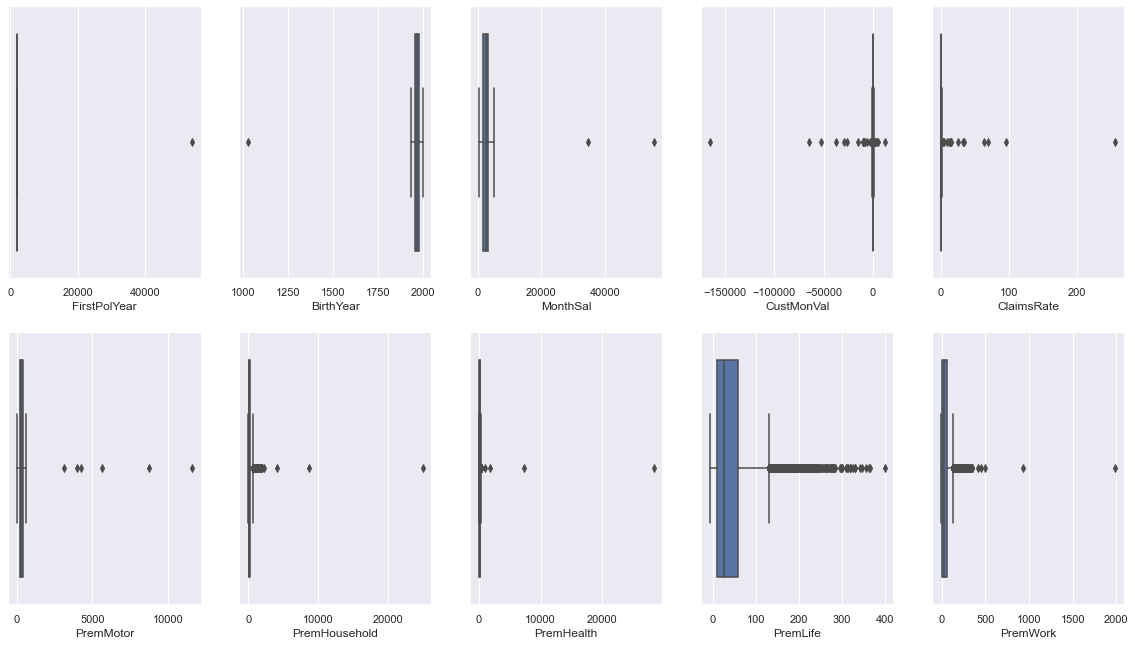

In [15]:
# boxplot of numeric variables to detect outliers
sns.set()

fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# iterate through axes objects and associate each box plot
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df[feat], ax=ax)
    
plt.show()

In [16]:
# assume that 1028 in BirthYear is a typo and in reality corresponds to 1928
# 0 and 9 are fairly close in a qwerty keyboard
df.loc[df.BirthYear == 1028, "BirthYear"] = 1928

# store outliers in a separate dataframe (to be assigned to a cluster in the end)
# remove outliers from main dataframe, df
len_df = len(df)
filters = ((df.FirstPolYear.ge(2017)),
           (df.MonthSal.ge(20000)),
           (df.CustMonVal.le(-2000)),
           (df.CustMonVal.ge(1500)),
           (df.ClaimsRate.ge(4)),
           (df.PremMotor.ge(3000)),
           (df.PremHousehold.ge(1600)),
           (df.PremHealth.ge(5000)),
           (df.PremWork.ge(300)))
df_outliers = pd.DataFrame()

for filter_ in filters:
    df_outliers = df_outliers.append(df[filter_])
    df = df[~filter_]

# compute number of outliers removed
n_outliers = len(df_outliers)
perc_removed = round(n_outliers/len_df*100, 2)
print(f"Number of outliers removed: {n_outliers} ({perc_removed}% of all observations)")

Number of outliers removed: 55 (0.53% of all observations)


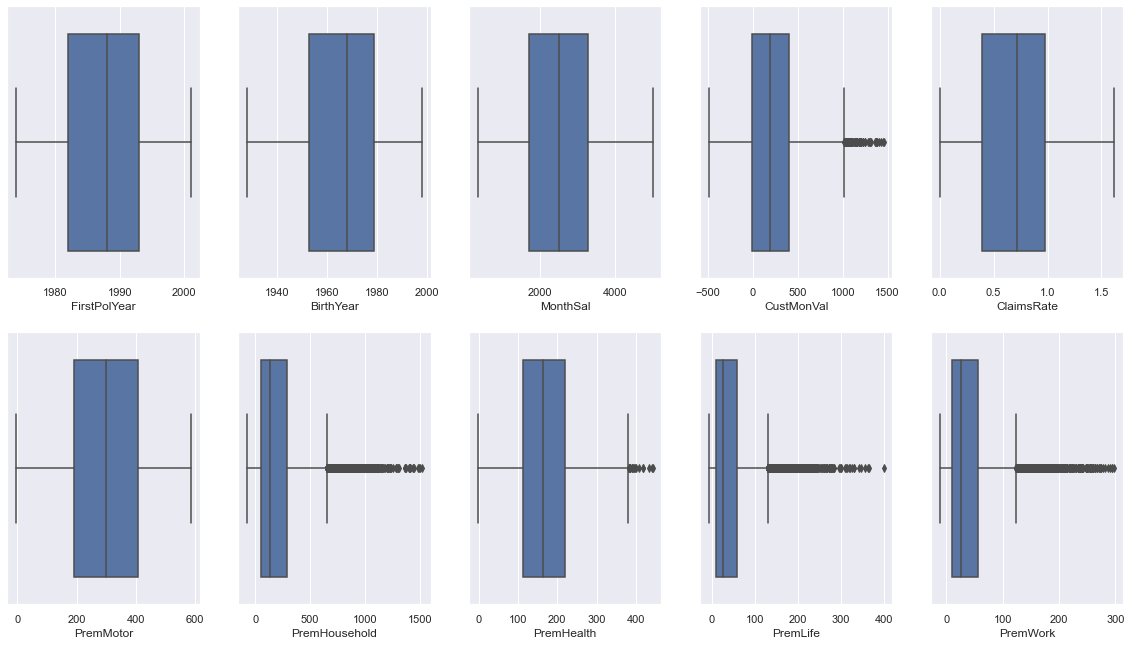

In [17]:
# boxplots of numeric variables after removing outliers
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df[feat], ax=ax)
    
plt.show()

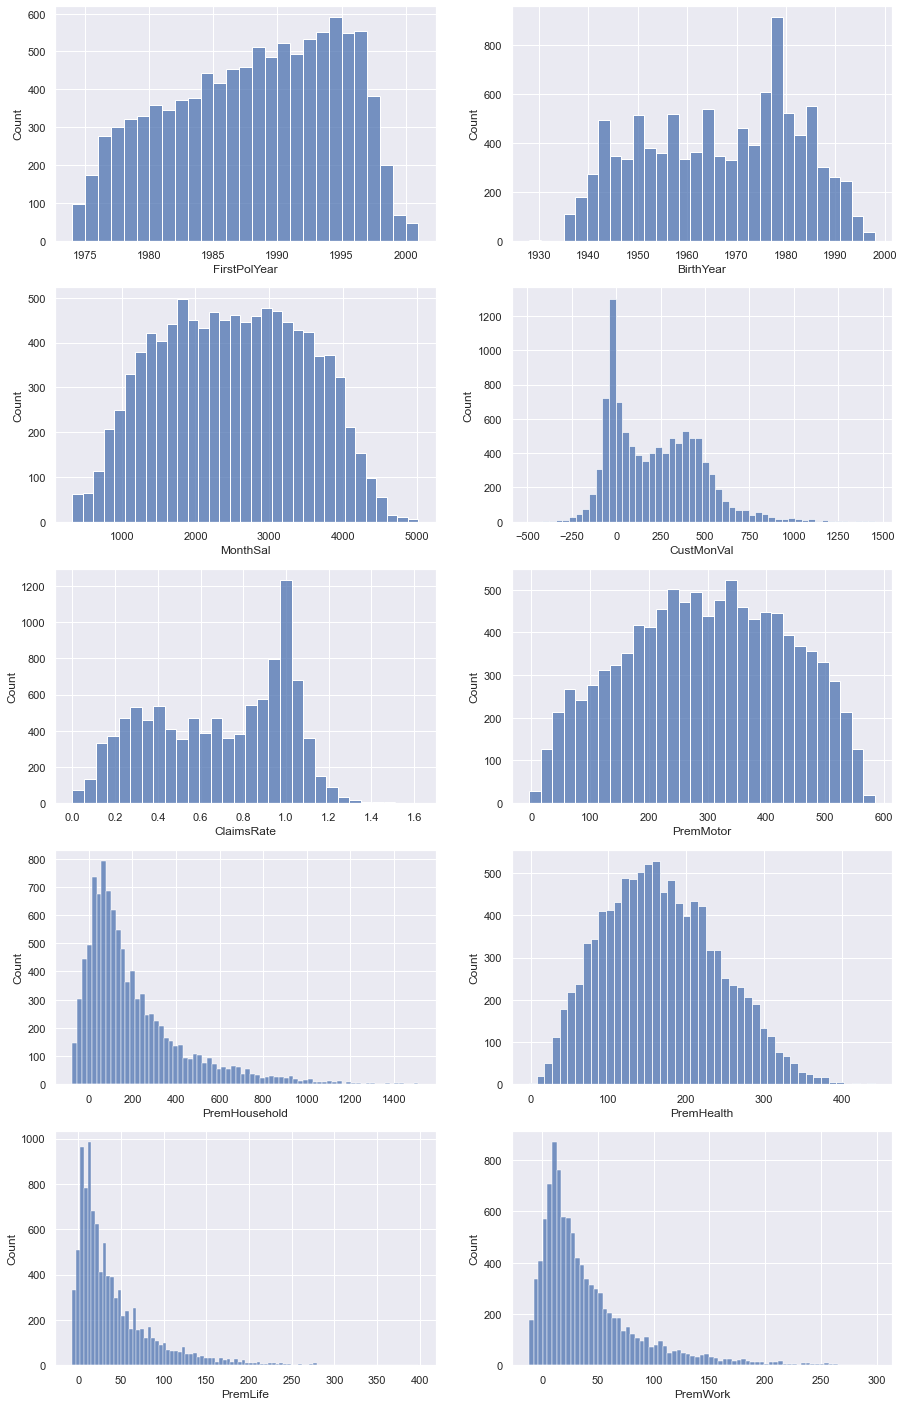

In [18]:
# histograms of metric features

sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(5, 2, figsize=(15, 25))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features):
    sns.histplot(x=df[feat], ax=ax)
    
plt.show()

# maybe deal with skewness here ??????????

In [19]:
# new look at the data after removing outliers
df.describe(include="all").T

count unique  top    freq         mean         std     min  \
FirstPolYear   10208.0    NaN  NaN     NaN  1987.629604    6.540021  1974.0   
BirthYear      10221.0    NaN  NaN     NaN   1966.42491   15.468052  1928.0   
EducDeg          10221      4    3    4782          NaN         NaN     NaN   
MonthSal       10202.0    NaN  NaN     NaN  2501.489316  982.555692   333.0   
GeoLivArea     10237.0    4.0  4.0  4120.0          NaN         NaN     NaN   
Children       10217.0    2.0  1.0  7222.0          NaN         NaN     NaN   
CustMonVal     10238.0    NaN  NaN     NaN    217.14454  254.723434  -490.2   
ClaimsRate     10238.0    NaN  NaN     NaN     0.680096    0.318477     0.0   
PremMotor      10205.0    NaN  NaN     NaN   297.623278  137.655141   -4.11   
PremHousehold  10238.0    NaN  NaN     NaN   205.072998  230.564861   -75.0   
PremHealth     10196.0    NaN  NaN     NaN   168.115505   74.095068   -2.11   
PremLife       10135.0    NaN  NaN     NaN     41.81805   47.492666    -7.0   
PremWork       10152.0    NaN  NaN     NaN     40.49038   45.289665   -12.0   

                  25%     50%       75%      max  
FirstPolYear   1982.0  1988.0    1993.0   2001.0  
BirthYear      1953.0  1968.0    1979.0   1998.0  
EducDeg           NaN     NaN       NaN      NaN  
MonthSal       1711.0  2504.0    3291.0   5021.0  
GeoLivArea        NaN     NaN       NaN      NaN  
Children          NaN     NaN       NaN      NaN  
CustMonVal    -9.1925  187.04  398.8675  1455.94  
ClaimsRate       0.39    0.72      0.98     1.62  
PremMotor      191.48  299.28     408.3   585.22  
PremHousehold   49.45   132.8     289.5  1513.05  
PremHealth     111.91  162.92    219.82   442.86  
PremLife         9.89   25.56     57.79    398.3  
PremWork        10.67   25.67     56.01    298.5

Dealing with missing values.

In [20]:
# checking feature completeness
nan_byfeature = df.isna().sum()
nan_pc_byfeature = df.isna().mean()*100
feature_nans = pd.concat([nan_byfeature, nan_pc_byfeature], axis=1)
feature_nans.rename(columns = {0: 'nr', 1: '%'}, inplace=True)
print('Missing values per feature:\n', feature_nans)

# checking max number of missing values per row
row_nan_count = []
for row in range(len(df)):
    row_nan_count.append(df.iloc[row].isna().sum())
print('\nMax NaN per row:', np.max(row_nan_count))

# not enough missing values in a single feature to merit excluding that feature
# not enough missing values in a single row to merit excluding those observations

Missing values per feature:
                 nr         %
FirstPolYear    30  0.293026
BirthYear       17  0.166048
EducDeg         17  0.166048
MonthSal        36  0.351631
GeoLivArea       1  0.009768
Children        21  0.205118
CustMonVal       0  0.000000
ClaimsRate       0  0.000000
PremMotor       33  0.322329
PremHousehold    0  0.000000
PremHealth      42  0.410236
PremLife       103  1.006056
PremWork        86  0.840008

Max NaN per row: 4


In [21]:
# remove rows with missing FirstPolYear and missing BirthYear
# removes a total of 44 rows
df = df[~df.FirstPolYear.isna()]
df = df[~df.BirthYear.isna()]

# remove rows with missing EducDeg
# removes 2 rows (only 2 NaN remaining after removing NaNs in year columns)
df = df[~df.EducDeg.isna()]

# replace NaN in Premiums with 0
# assumes no info about Premiums means no premium is paid
df.PremMotor.fillna(0, inplace=True)
df.PremHealth.fillna(0, inplace=True)
df.PremLife.fillna(0, inplace=True)
df.PremWork.fillna(0, inplace=True)

# replace missing MonthSal values with mean salary
# df.MonthSal.fillna(df.MonthSal.mean(), inplace=True)

In [22]:
# create a linear regression model to impute missing MonthSal values
# use all features but the MonthSal to train the model

# define independent and dependent variables
#X = df.dropna().drop(["MonthSal"], axis = 1)
#y = df.dropna().MonthSal

# split train and test data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

# scale train and test data
#scaler = MinMaxScaler().fit(X_train)
#X_train_scaled = scaler.transform(X_train)
#X_test_scaled = scaler.transform(X_test)

# create and fit model
#lin_model = LinearRegression()
#lin_model.fit(X_train_scaled, y_train)

# predict y
#y_pred = lin_model.predict(X_test_scaled)

# evaluate the predictions of the linear reg model
#xlabels = X_train.columns
#stats.summary(clf = lin_model, X = X_train_scaled, y = y_train, xlabels = xlabels)
#mse = mean_squared_error(y_test, y_pred)
#rmse = mean_squared_error(y_test, y_pred, squared = False)
#mae = mean_absolute_error(y_test, y_pred)

# mse 171348
#print(mse)
# rmse 414
#print(rmse)
# mae 330
#print(mae)

In [23]:
# create a linear regression model to impute missing MonthSal values
# use only Age to train the model (found to have 0.9 correlation with MonthSal)
# justify this in the report: single linear regression seemed better suited than a multiple linear regression
# 1: explains almost all of the variance
# 2: produces only slightly bigger errors
# 3: other OLS algebraic properties or whatnot ???

# define independent and dependent variables
X = df.dropna().BirthYear
y = df.dropna().MonthSal

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)
X_train = np.array(X_train).reshape(-1,1)
X_test = np.array(X_test).reshape(-1,1)

# scale train and test data
#scaler = MinMaxScaler().fit(np.array(X_train).reshape(-1,1))
#X_train_scaled = scaler.transform(np.array(X_train).reshape(-1,1))
#X_test_scaled = scaler.transform(np.array(X_test).reshape(-1,1))

# create and fit model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# predict y
y_pred = lin_model.predict(X_test)

# evaluate the predictions of the linear reg model
#xlabels = "CustID"
stats.summary(clf = lin_model, X = X_train, y = y_train)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
mae = mean_absolute_error(y_test, y_pred)

# mse 178876
print(mse)
# rmse 423
print(rmse)
# mae 333
print(mae)

Residuals:
       Min        1Q   Median       3Q       Max
-1513.5206 -290.4269 -13.2861 268.4494 1734.4503


Coefficients:
                 Estimate  Std. Error     t value  p value
_intercept  115568.866430  633.534103    182.4193      0.0
x1             -57.498184    0.002689 -21381.9972      0.0
---
R-squared:  0.81769,    Adjusted R-squared:  0.81767
F-statistic: 31845.02 on 1 features
178875.80928702894
422.93712214350364
333.3451015075628


In [24]:
# model shows that increasing BirthYear by 1 (being 1 year younger) is expected to decrease monthly salary by 57.50€
# do we need to formally reject H0: beta1hat = 0 ?

In [25]:
# predict MonthSal NaN values
X_test = np.array(df[df.MonthSal.isna()].BirthYear).reshape(-1,1)
y_pred = lin_model.predict(X_test)

# impute values to MonthSal NaN
df.loc[df.MonthSal.isna(), "MonthSal"] = y_pred

In [26]:
# create a logistic regression model to impute missing Children values
# split df into data and target
data = df.dropna().drop(["Children", "GeoLivArea"], axis = 1)
target = df.dropna().Children

# split data into train (70%) and test (30%) datasets
# 70% have children, 30% dont, might need stratify = target
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=5, stratify = target)

# scale features using MinMaxScaler() with parameters from X_train
scaler = MinMaxScaler().fit(X_train)
# scale the training set
X_train_scaled = scaler.transform(X_train)
# scale the test set
X_test_scaled = scaler.transform(X_test)

# create a logistic regression model
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)

# predict y
y_pred = log_model.predict(X_test_scaled)

# evaluate the predictions of the logistic reg model
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
precision = round(precision_score(y_test, y_pred)*100, 2)
recall = round(recall_score(y_test, y_pred)*100, 2)
f1 = round(f1_score(y_test, y_pred)*100, 2)

print("Confusion matrix:\n", conf_matrix)
print("Accuracy:", accuracy, "%")
print("Precision:", precision, "%")
print("Recall:", recall, "%")
print("F1 score:", f1, "%")

Confusion matrix:
 [[ 582  313]
 [ 166 1993]]
Accuracy: 84.32 %
Precision: 86.43 %
Recall: 92.31 %
F1 score: 89.27 %


In [27]:
# predict Children NaN values
X_test = df[df.Children.isna()].drop(columns=["Children", "GeoLivArea"])
X_test_scaled = scaler.transform(X_test)
y_pred = log_model.predict(X_test_scaled)

# impute values to Children NaN
df.loc[df.Children.isna(), "Children"] = y_pred

In [28]:
# check if all missing values were dealt with
df.isna().sum()

FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

## Data transformation (and more cross-field validation)

In [29]:
# create an Age column (present year considered to be 2016)
curr_year = 2016
ages = curr_year - df.BirthYear
# insert ages as the 3rd feature, after BirthYear
df.insert(2, "Age", ages)

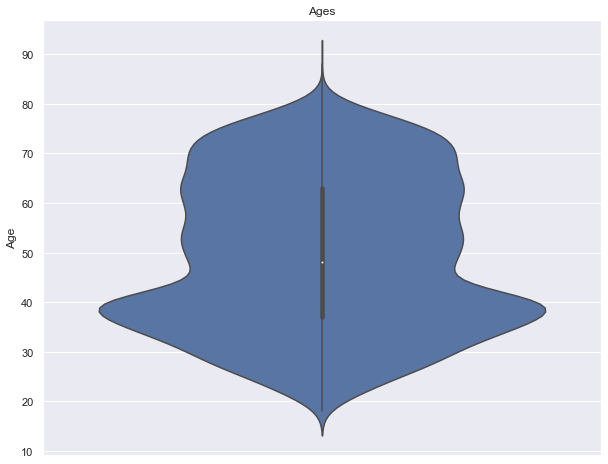

count    10192.000000
mean        49.567504
std         15.464799
min         18.000000
25%         37.000000
50%         48.000000
75%         63.000000
max         88.000000
Name: Age, dtype: float64

In [30]:
# plot distribution of ages
plt.figure(figsize=(10,8))
plt.title("Ages")
sns.axes_style("dark")
sns.violinplot(y=df["Age"])
plt.show()

# get some stats regarding the Age column
df.Age.describe()

In [31]:
# check if EducDeg makes sense according to Age
# min age is 18 so everyone can have an education up to High School
# check youngest people with a BSc/MSc
print("Minimum age associated to each Education Degree:")
print(df.groupby("EducDeg").Age.min())

# finishing a BSc (EducDeg = 3) at 20 yo is possible if starting at 17
# finishing a PhD (EducDeg = 4) at 23 yo is possible if skipping MSc and finishing PhD in 3 years (UK or outside of EU)
# no incoherences in EducDeg

Minimum age associated to each Education Degree:
EducDeg
1    18.0
2    19.0
3    20.0
4    23.0
Name: Age, dtype: float64


In [32]:
# create a Generation column based on birth year
# could use LabelEncoder or OrdinalEncoder here but I couldn't make it work??????????????
df.loc[(df.BirthYear >= 1928) & (df.BirthYear <= 1945), "Generation"] = 1 # Silent Gen
df.loc[(df.BirthYear >= 1946) & (df.BirthYear <= 1964), "Generation"] = 2 # Baby Boomer
df.loc[(df.BirthYear >= 1965) & (df.BirthYear <= 1980), "Generation"] = 3 # Gen X
df.loc[(df.BirthYear >= 1981) & (df.BirthYear <= 1995), "Generation"] = 4 # Millennial
df.loc[(df.BirthYear >= 1996) & (df.BirthYear <= 2010), "Generation"] = 5 # Gen Z

# generation mapper
gen_mapper = {1: "Silent Gen",
              2: "Baby Boomer",
              3: "Gen X",
              4: "Millennial",
              5: "Gen Z"}

# convert Generation data to categorical
df.Generation = df.Generation.astype("category")

# get some stats regarding the Generation column
df.Generation.describe()

count     10192.0
unique        5.0
top           3.0
freq       3441.0
Name: Generation, dtype: float64

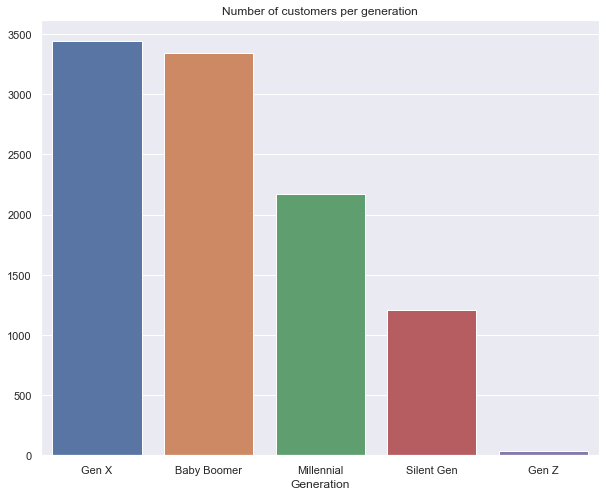

In [33]:
# count number of customers per generation
gen_count = df.groupby("Generation").size().sort_values(ascending = False)
gen_count.rename(index = gen_mapper, inplace = True)

# plot number of customers per generation
plt.figure(figsize=(10,8))
plt.title("Number of customers per generation")
sns.axes_style("dark")
sns.barplot(x = gen_count.index, y = gen_count.values, order = gen_count.index)
plt.show()

In [34]:
# create a YearSal column
# Premiums are also expressed as yearly values
# could be interesting to try YearSal as a categorical variable???
df.insert(5, "YearSal", df.MonthSal*12)

count    10192.000000
mean       750.818412
std        190.346723
min          0.000000
25%        626.240000
50%        697.130000
75%        823.032500
max       1804.440000
Name: PremTotal, dtype: float64


<AxesSubplot:xlabel='PremTotal'>

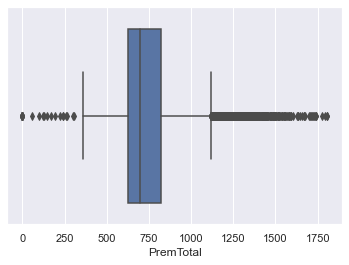

In [35]:
# create a PremTotal column
premium_cols = ["PremMotor", "PremHousehold", "PremHealth", "PremLife", "PremWork"]
df["PremTotal"] = df[premium_cols].sum(axis = 1)

# get some stats regarding the PremTotal column
print(df.PremTotal.describe())

# deal with PremTotal outliers??????????????
sns.boxplot(x = df.PremTotal)

In [36]:
# no observations where PremTotal is higher than the yearly salary
len(df[df.PremTotal > df.YearSal])

0

In [37]:
# what to do when no premiums were paid in 2016?????
# it could mean that the insurance was cancelled and they are no longer customers

# 12 observations with no Premiums paid in 2016
print(f"{len(df[df.PremTotal == 0])} customer(s) paid no Premium")
# removed these 12 observations as they likely represent past customers
df = df[~(df.PremTotal == 0)]

12 customer(s) paid no Premium


In [38]:
# create a CustYears column
# number of years a customer has been a customer
df["CustYears"] = curr_year - df.FirstPolYear

# get some stats regarding the CustYears column
df.CustYears.describe()

count    10180.000000
mean        28.368173
std          6.537370
min         15.000000
25%         23.000000
50%         28.000000
75%         34.000000
max         42.000000
Name: CustYears, dtype: float64

In [39]:
# PremHousehold, PremLife, PremWork skewed to the right
# probably need to apply a transformation? however...
# sqrt does not keep sign, maybe cube root?
# log cannot be applied without first dealing with the negative values (sum min val?)

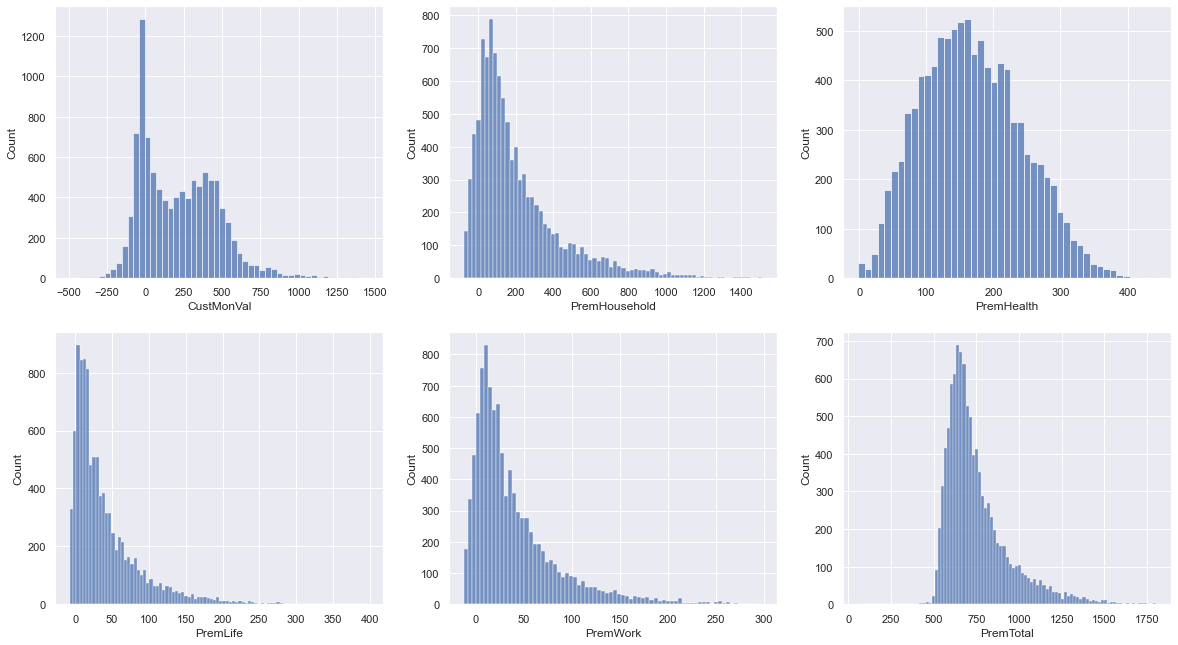

In [40]:
# CustMonVal, PremHousehold, PremHealth, PremLife, PremWork may require further processing
# histograms
skewed_metric_features = ["CustMonVal", "PremHousehold", "PremHealth", "PremLife", "PremWork", "PremTotal"]

sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, 3, figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), skewed_metric_features):
    sns.histplot(x=df[feat], ax=ax)
    
plt.show()

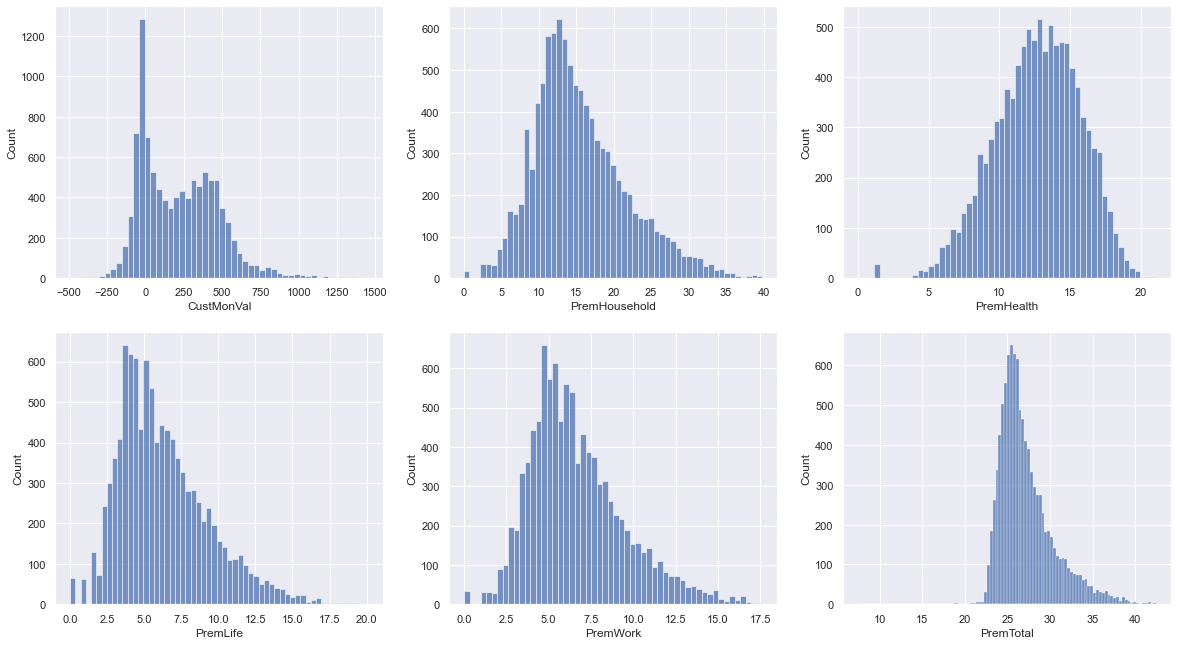

In [41]:
# summing the module of the minimum value to all observations
# applying transformation to normalize distributions
df.PremHousehold = np.sqrt(df.PremHousehold + 75)
df.PremHealth = np.sqrt(df.PremHealth + 2.11)
df.PremLife = np.sqrt(df.PremLife + 7)
df.PremWork = np.sqrt(df.PremWork + 12)
df.PremTotal = np.sqrt(df.PremTotal)

sns.set()

fig, axes = plt.subplots(2, 3, figsize=(20, 11))

for ax, feat in zip(axes.flatten(), skewed_metric_features):
    sns.histplot(x=df[feat], ax=ax)
    
plt.show()

In [42]:
# percentage of observations discarded
num_obs_discarded = len_df-len(df)
pc_obs_discarded = round(num_obs_discarded/len_df*100, 2)
print(f"Number of observations discarded: {num_obs_discarded} ({pc_obs_discarded} %)")

Number of observations discarded: 113 (1.1 %)


In [43]:
# new look at the dataframe
df

FirstPolYear  BirthYear   Age EducDeg  MonthSal  YearSal GeoLivArea  \
CustID                                                                        
1             1985.0     1982.0  34.0       2    2177.0  26124.0        1.0   
2             1995.0     1981.0  35.0       2     677.0   8124.0        4.0   
3             1991.0     1970.0  46.0       1    2277.0  27324.0        3.0   
4             1990.0     1981.0  35.0       3    1099.0  13188.0        4.0   
5             1986.0     1973.0  43.0       3    1763.0  21156.0        4.0   
...              ...        ...   ...     ...       ...      ...        ...   
10292         1984.0     1949.0  67.0       4    3188.0  38256.0        2.0   
10293         1977.0     1952.0  64.0       1    2431.0  29172.0        3.0   
10294         1994.0     1976.0  40.0       3    2918.0  35016.0        1.0   
10295         1981.0     1977.0  39.0       1    1971.0  23652.0        2.0   
10296         1990.0     1981.0  35.0       4    2815.0  33780.0        1.0   

       Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
CustID                                                                          
1           1.0      380.97        0.39     375.85      12.427791   12.184827   
2           1.0     -131.13        1.12      77.46      22.163032   10.899541   
3           0.0      504.67        0.28     206.15      17.306068   11.255665   
4           1.0      -16.99        0.99     182.48      10.878879   17.699718   
5           1.0       35.23        0.90     338.62      11.081516   13.590438   
...         ...         ...         ...        ...            ...         ...   
10292       0.0       -0.11        0.96     393.74      11.155716   13.263484   
10293       0.0     1405.60        0.00     133.58      33.327916   12.056533   
10294       1.0      524.10        0.21     403.63      14.415270   12.014991   
10295       1.0      250.05        0.65     188.59      16.915969   14.159096   
10296       1.0      463.75        0.27     414.08      13.017296   11.973304   

         PremLife   PremWork Generation  PremTotal  CustYears  
CustID                                                         
1        7.349150   5.374942        4.0  25.798450       31.0  
2       14.194365  10.868763        4.0  30.182114       21.0  
3        9.661780  10.536603        3.0  27.213967       25.0  
4        6.506919   6.351378        4.0  24.508774       26.0  
5        5.077401   7.310951        3.0  25.084657       30.0  
...           ...        ...        ...        ...        ...  
10292    4.096340   5.174940        2.0  25.329035       32.0  
10293    4.459821  10.822661        2.0  37.823273       39.0  
10294    4.435087   4.109745        3.0  26.386360       22.0  
10295    8.420214  11.176314        3.0  27.837385       35.0  
10296    3.726929   4.988988        4.0  25.875857       26.0  

[10180 rows x 18 columns]

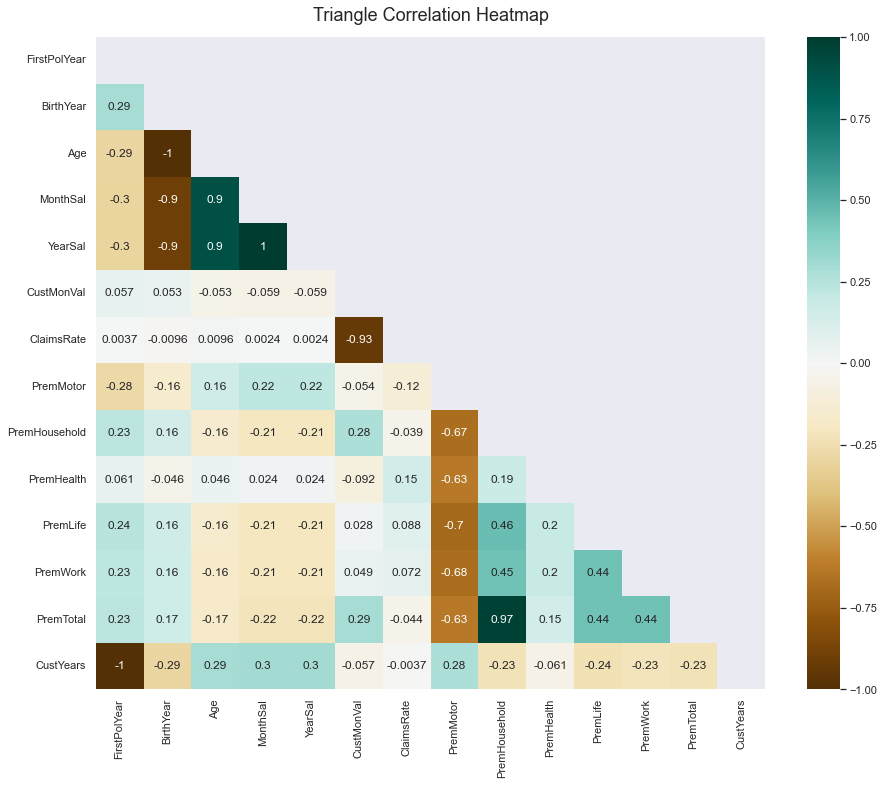

In [44]:
# create a heatmap showing correlation between all metric attributes
# pearson, spearman ????????????????
plt.subplots(figsize=(15,12))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
corr_heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
corr_heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [45]:
# high correlations:
# FirstPoLYear redundant with CustYears, remove FirstPoLYear as the latter is more intuitive to work with
# Age redundant with BirthYear, remove BirthYear as Age is more intuitive to work with
# MonthSal redundant with YearSal, remove MonthSal as Premiums are also yearly values
# CustMonVal redundant with ClaimsRate, and ClaimsRate not correlated with anything else, remove ClaimsRate
# 
df.drop(columns = ["FirstPolYear", "BirthYear", "ClaimsRate", "MonthSal"], inplace = True)

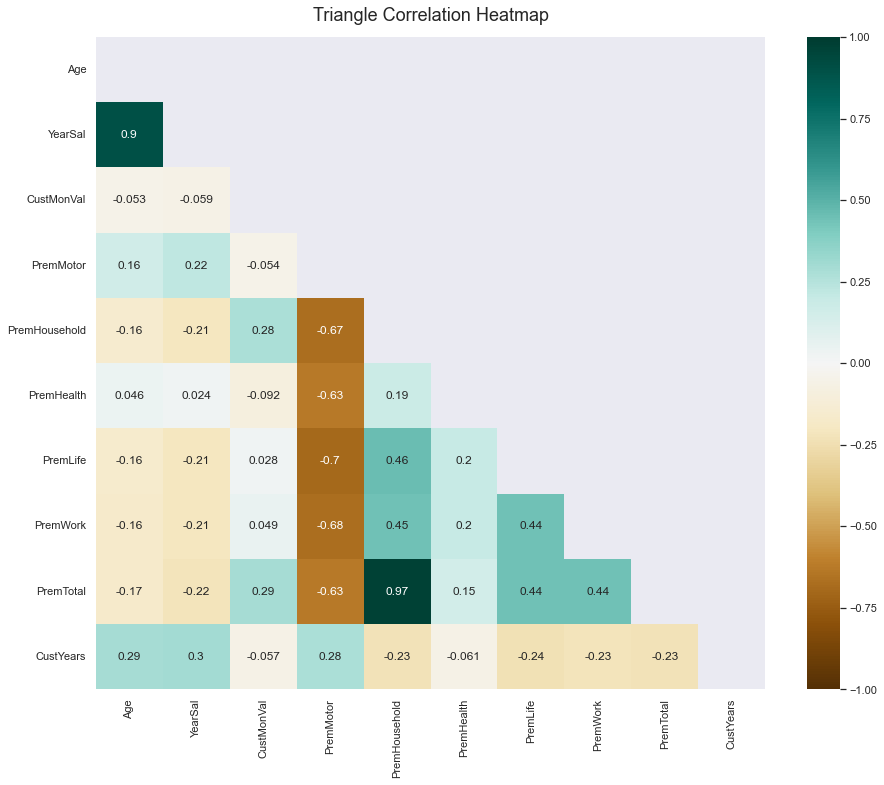

In [46]:
# create a heatmap showing correlation between the metric attributes selected
plt.subplots(figsize=(15,12))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
corr_heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
corr_heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

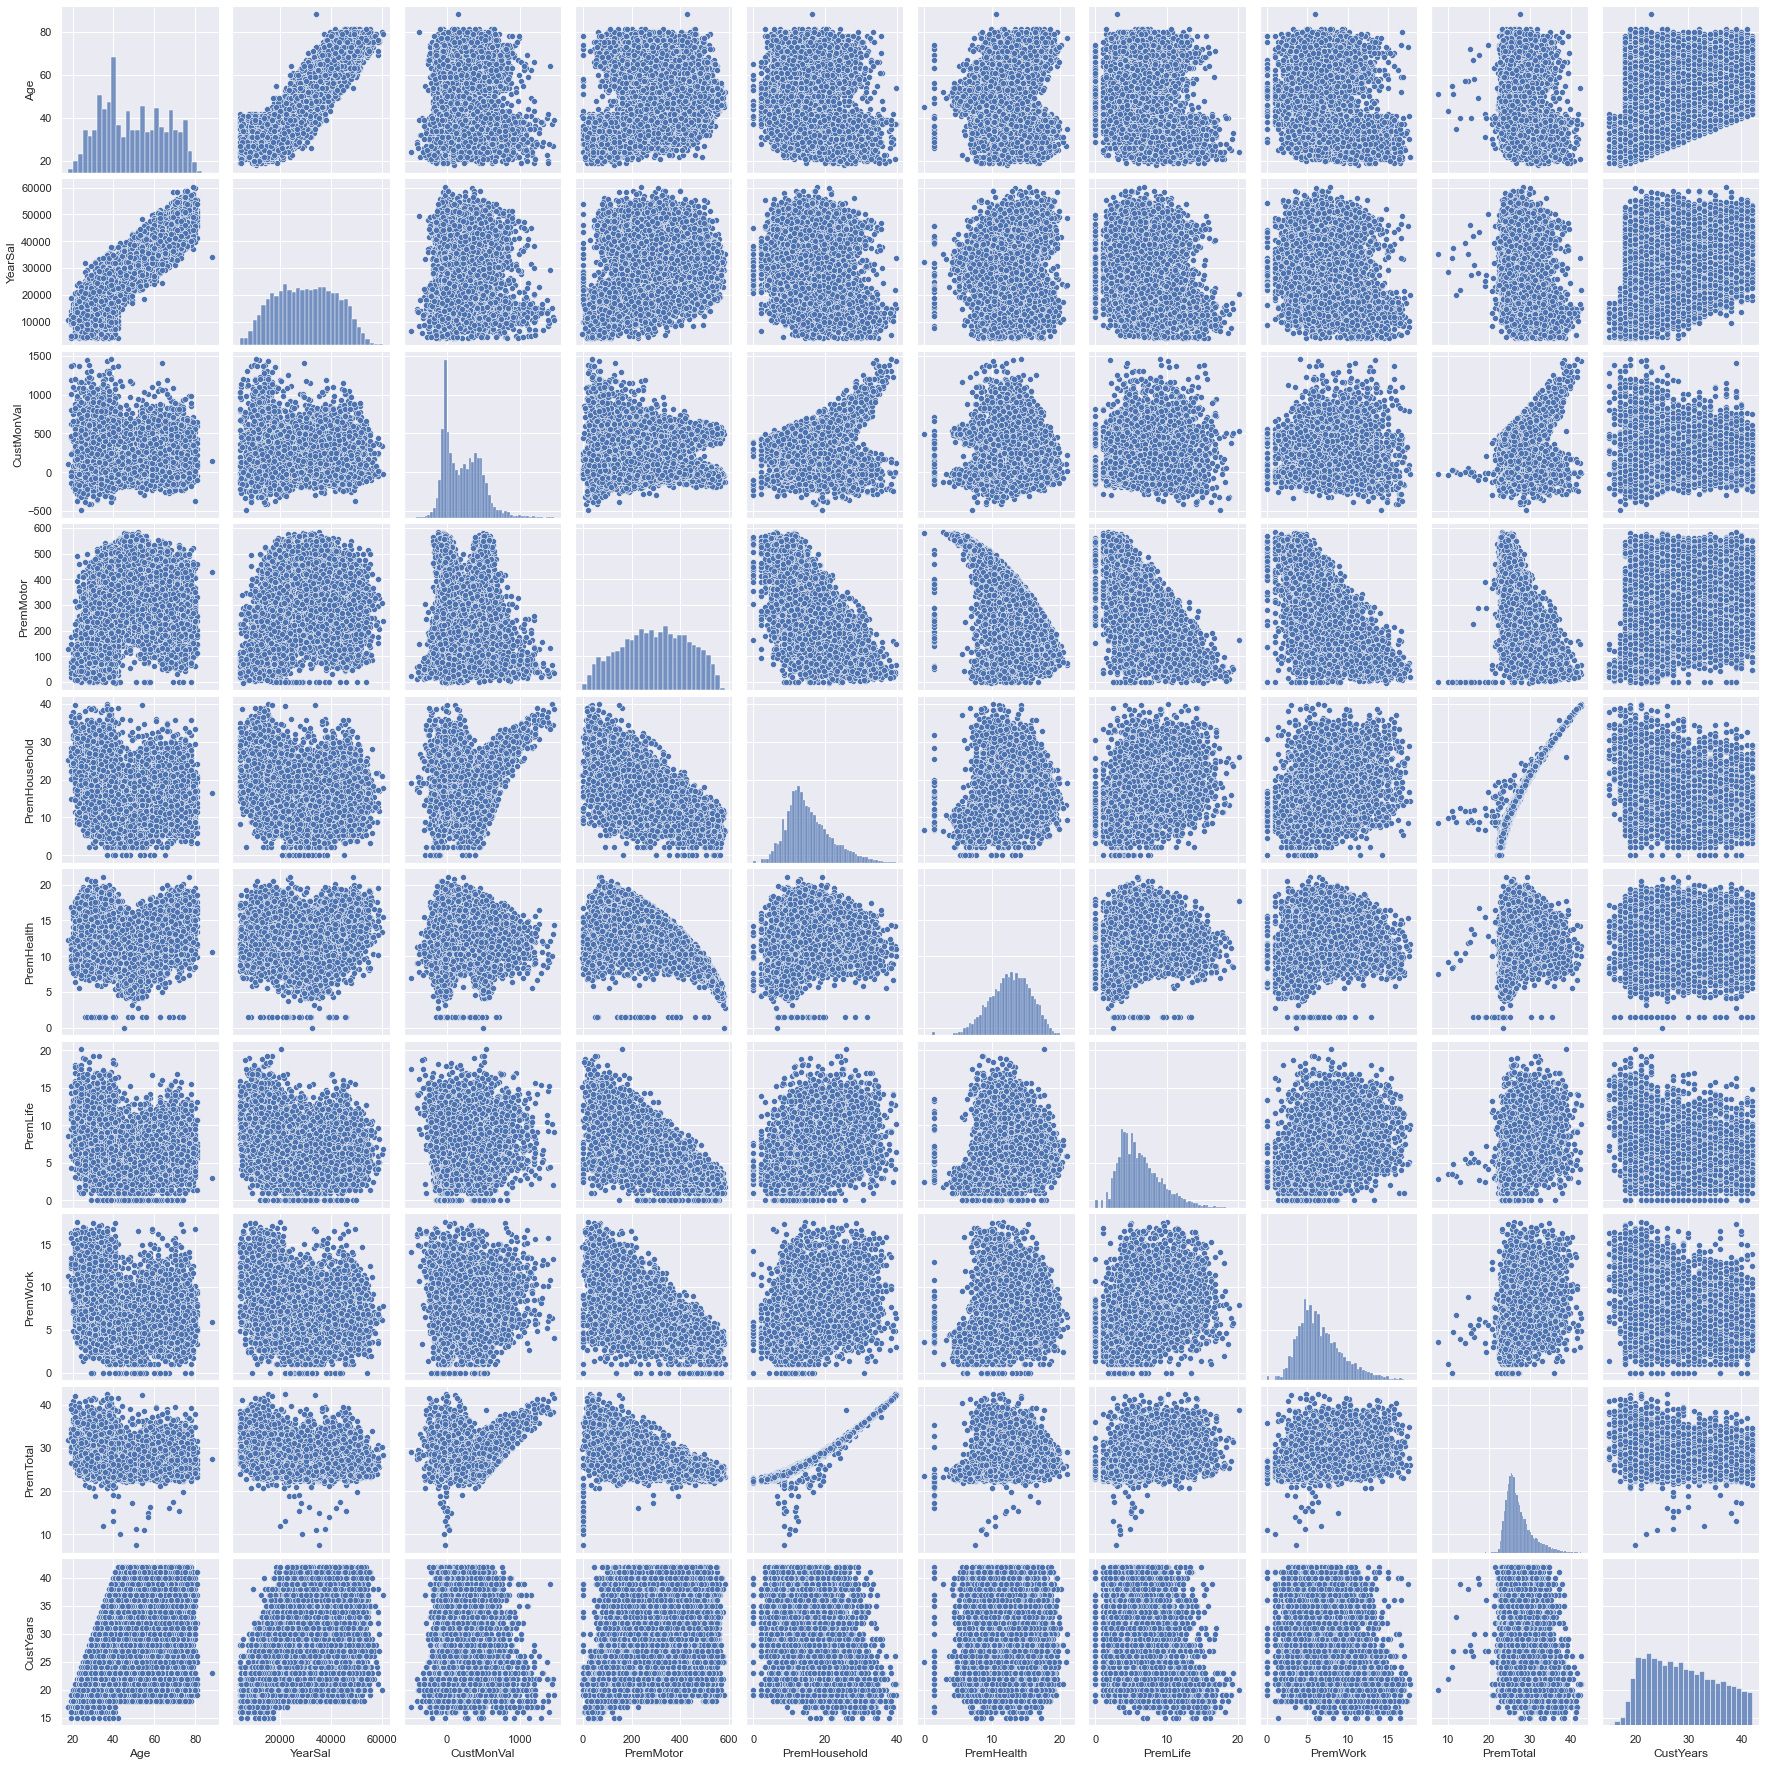

In [47]:
# bidimensional representation of metric attributes
sns.pairplot(df)

In [48]:
# updating metric and non-metric features
metric_features = df.select_dtypes(include = np.number).columns.tolist()
non_metric_features = df.columns.drop(metric_features).tolist()

print("Metric Features:", metric_features)
print("Non-metric Features:", non_metric_features)

Metric Features: ['Age', 'YearSal', 'CustMonVal', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork', 'PremTotal', 'CustYears']
Non-metric Features: ['EducDeg', 'GeoLivArea', 'Children', 'Generation']


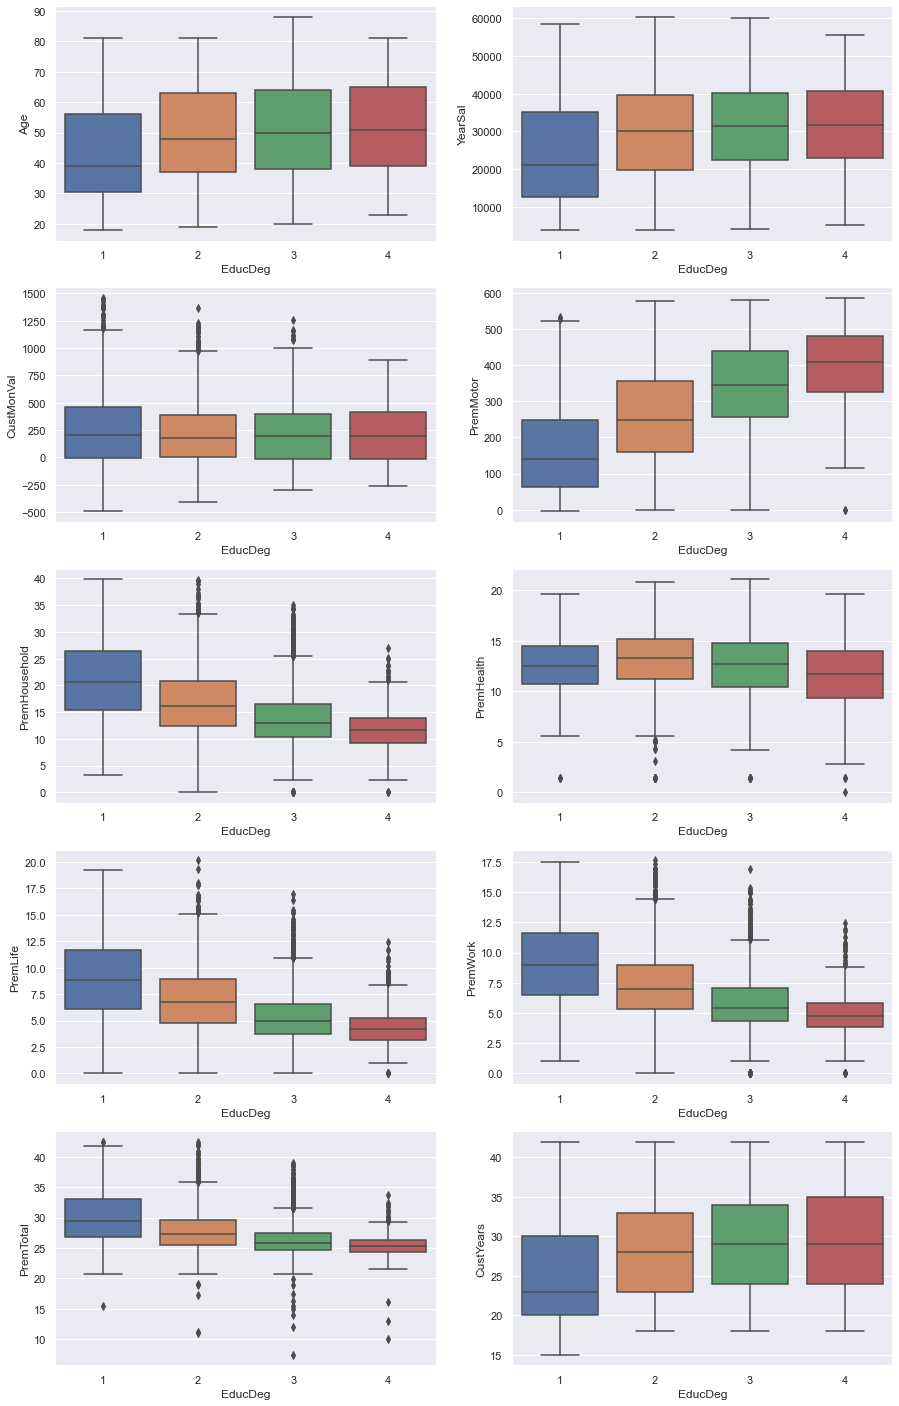

In [49]:
# explore EducDeg categorical feature
sns.set()

fig, axes = plt.subplots(5, 2, figsize=(15, 25))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df["EducDeg"], y=df[feat], ax=ax)
    
plt.show()

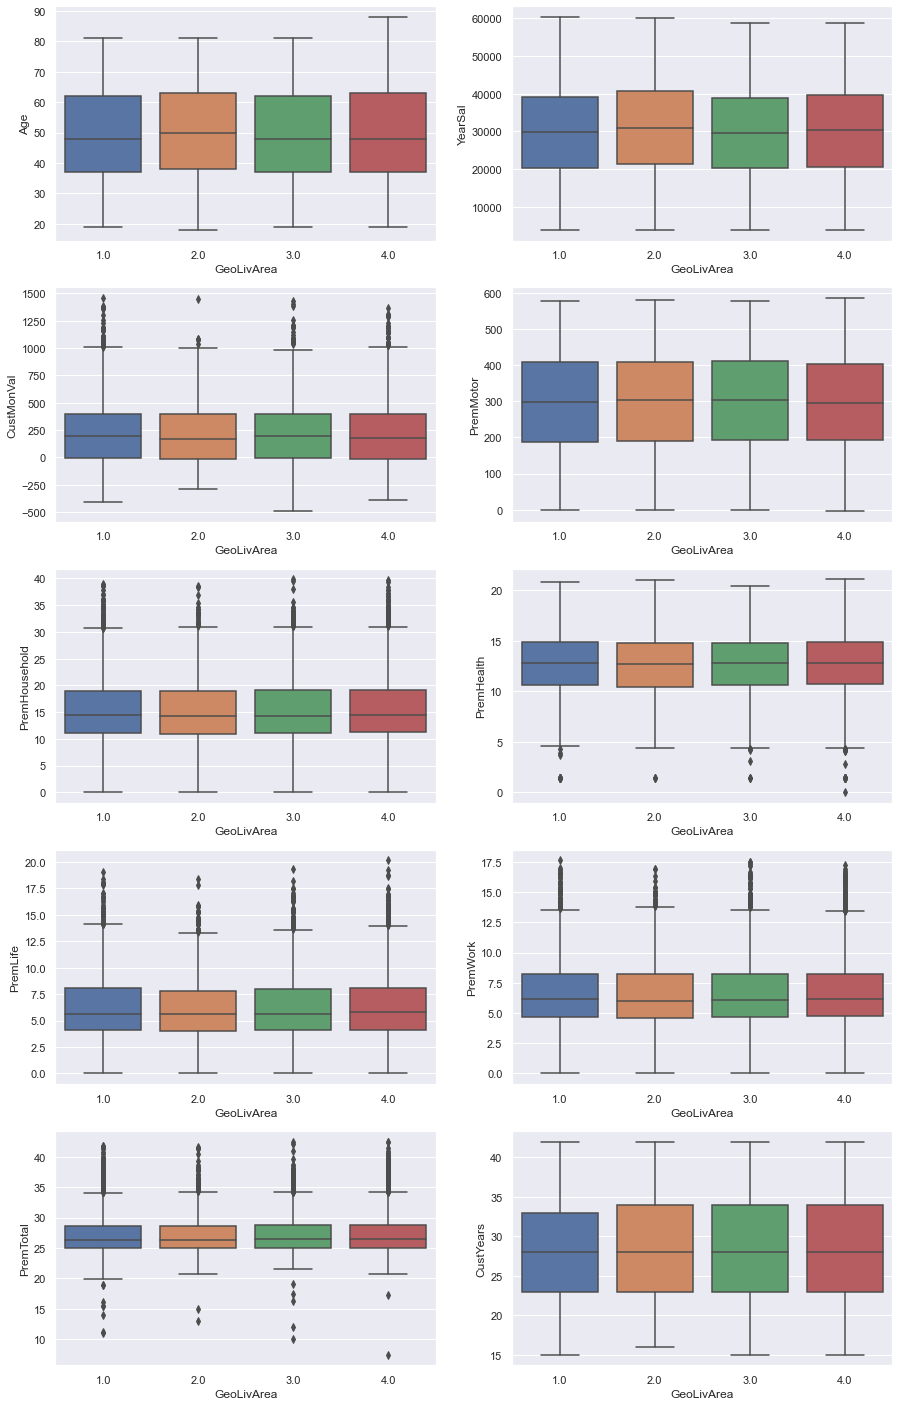

In [50]:
# we do not know much about GeoLivArea or how relevant it might be
# explore GeoLivArea categorical feature
sns.set()

fig, axes = plt.subplots(5, 2, figsize=(15, 25))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df["GeoLivArea"], y=df[feat], ax=ax)
    
plt.show()

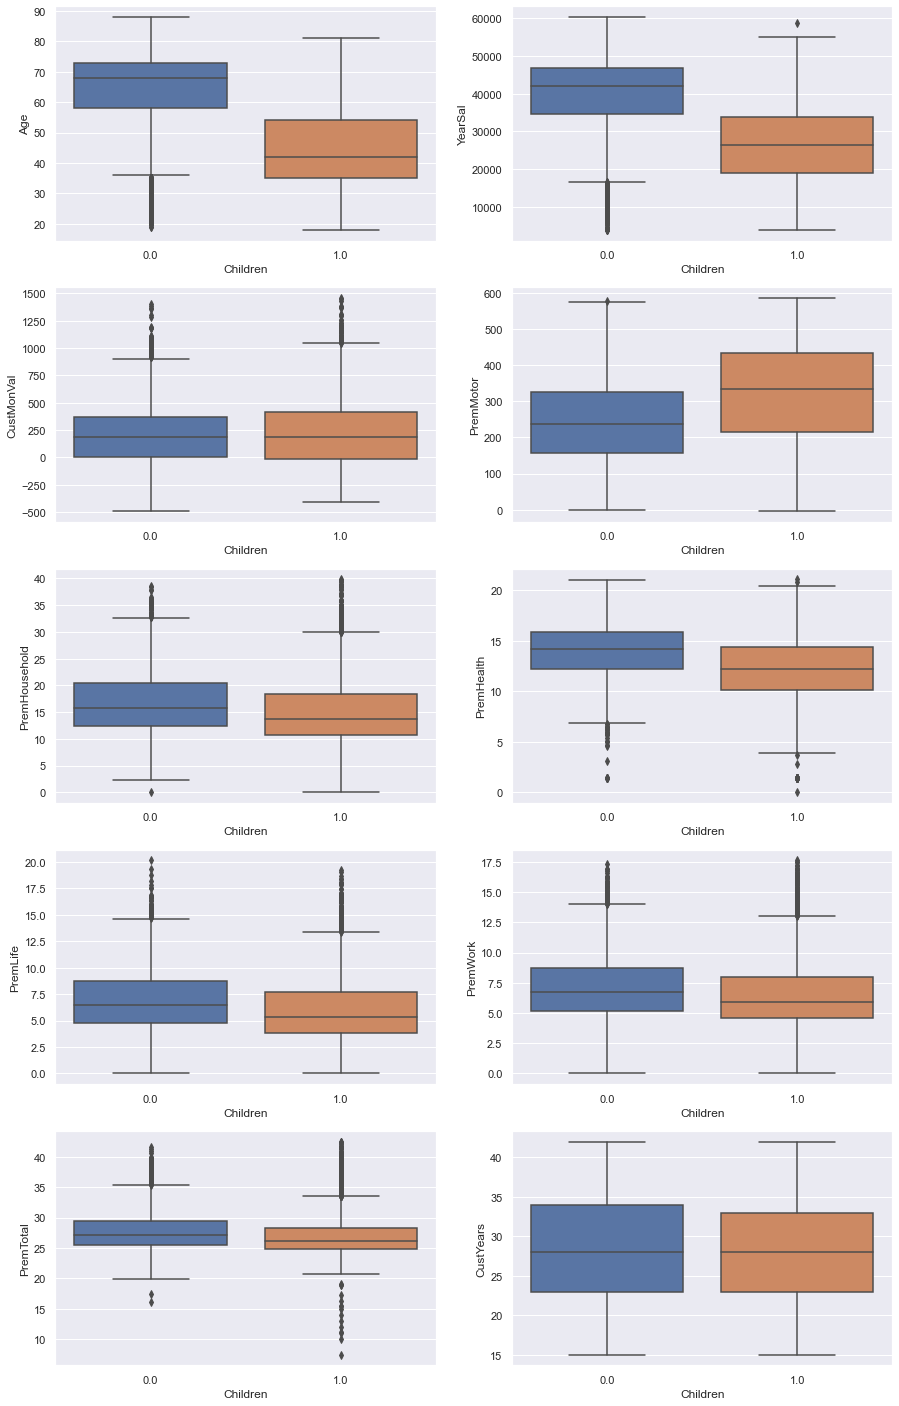

In [51]:
# explore Children categorical feature
sns.set()

fig, axes = plt.subplots(5, 2, figsize=(15, 25))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df["Children"], y=df[feat], ax=ax)
    
plt.show()

# kinda weird that median age of people with children is lower than for people without?

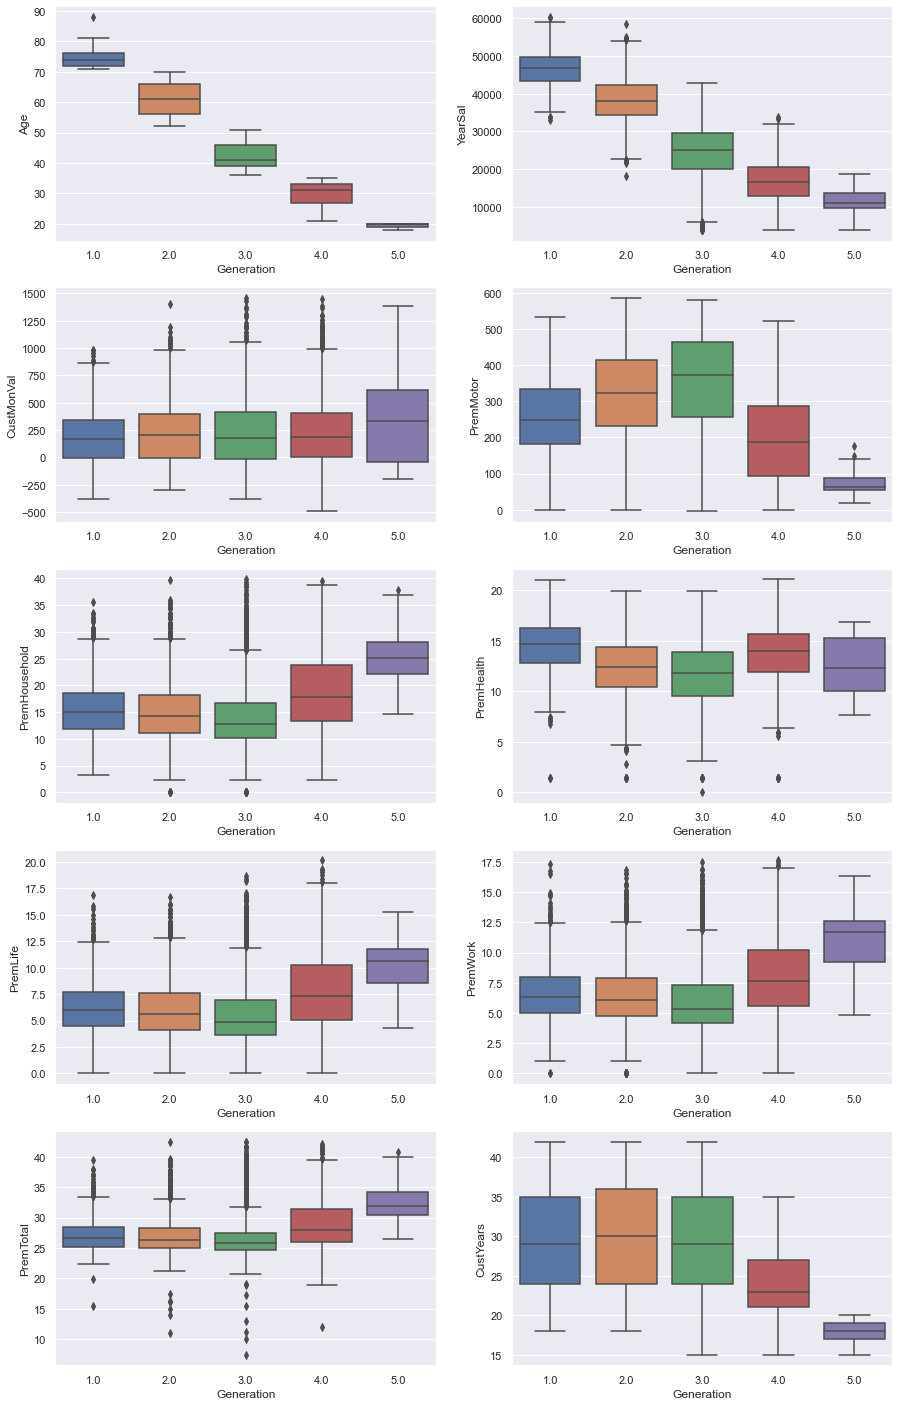

In [52]:
# explore Generation categorical feature
sns.set()

fig, axes = plt.subplots(5, 2, figsize=(15, 25))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df["Generation"], y=df[feat], ax=ax)
    
plt.show()

In [53]:
# Children and EducDeg appear to have some discriminating power
# Generation also appears to be interesting if we use age as categorical
# GeoLivArea does not seem to be particularly useful
df.drop(columns = "GeoLivArea", inplace = True)

# should we retrieve the 1 observation removed because GeoLivArea was NaN??????????

In [54]:
# reorganizing dataframe to be more intuitive
df = df.loc[:, ["Generation",
                "Age", 
                "EducDeg", 
                "Children", 
                "YearSal", 
                "CustYears", 
                "CustMonVal", 
                "PremMotor", 
                "PremHousehold", 
                "PremHealth", 
                "PremLife", 
                "PremWork", 
                "PremTotal"]]

df.head()

Generation   Age EducDeg Children  YearSal  CustYears  CustMonVal  \
CustID                                                                     
1             4.0  34.0       2      1.0  26124.0       31.0      380.97   
2             4.0  35.0       2      1.0   8124.0       21.0     -131.13   
3             3.0  46.0       1      0.0  27324.0       25.0      504.67   
4             4.0  35.0       3      1.0  13188.0       26.0      -16.99   
5             3.0  43.0       3      1.0  21156.0       30.0       35.23   

        PremMotor  PremHousehold  PremHealth   PremLife   PremWork  PremTotal  
CustID                                                                         
1          375.85      12.427791   12.184827   7.349150   5.374942  25.798450  
2           77.46      22.163032   10.899541  14.194365  10.868763  30.182114  
3          206.15      17.306068   11.255665   9.661780  10.536603  27.213967  
4          182.48      10.878879   17.699718   6.506919   6.351378  24.508774  
5          338.62      11.081516   13.590438   5.077401   7.310951  25.084657

## Scale metric features and encode categories as binary features

In [55]:
# updating metric and non-metric features

# EducDeg and Generation are ordinal, will be scaled as metric features
df.EducDeg = df.EducDeg.astype("float")
df.Generation = df.Generation.astype("float")
df.Children = df.Children.astype("float")

metric_features = df.select_dtypes(include = np.number).columns.tolist()
non_metric_features = df.columns.drop(metric_features).tolist()

print("Metric Features:", metric_features)
print("Non-metric Features:", non_metric_features)

Metric Features: ['Generation', 'Age', 'EducDeg', 'Children', 'YearSal', 'CustYears', 'CustMonVal', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork', 'PremTotal']
Non-metric Features: []


In [56]:
# scale metric features and store them as df_scaled
# alternative: StandardScaler (got better results with MinMaxScaler)
# create a dataframe with the scaled metric variables
df_scaled = df.copy()
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df_scaled[metric_features])
df_scaled[metric_features] = scaled_feat
df_scaled[metric_features].describe().round(2).T

count  mean  std   min   25%   50%   75%   max
Generation     10180.0  -0.0  1.0 -1.74 -0.69  0.36  0.36  2.46
Age            10180.0   0.0  1.0 -2.04 -0.81 -0.10  0.87  2.49
EducDeg        10180.0  -0.0  1.0 -1.87 -0.61  0.65  0.65  1.91
Children       10180.0   0.0  1.0 -1.55 -1.55  0.64  0.64  0.64
YearSal        10180.0   0.0  1.0 -2.21 -0.81  0.00  0.80  2.56
CustYears      10180.0  -0.0  1.0 -2.04 -0.82 -0.06  0.86  2.09
CustMonVal     10180.0  -0.0  1.0 -2.78 -0.89 -0.12  0.71  4.86
PremMotor      10180.0   0.0  1.0 -2.18 -0.77  0.01  0.80  2.09
PremHousehold  10180.0   0.0  1.0 -2.47 -0.69 -0.18  0.57  3.87
PremHealth     10180.0  -0.0  1.0 -4.20 -0.66  0.06  0.73  2.79
PremLife       10180.0   0.0  1.0 -2.08 -0.72 -0.19  0.57  4.60
PremWork       10180.0   0.0  1.0 -2.37 -0.70 -0.19  0.56  3.90
PremTotal      10180.0   0.0  1.0 -6.12 -0.68 -0.25  0.45  4.72

In [57]:
# there are two dataframes at this point
# the dataframe obtained prior to normalisation
# note: premium values are actually the square root of the original values
df.describe(include="all").T

count          mean           std          min           25%  \
Generation     10180.0      2.653831      0.953177     1.000000      2.000000   
Age            10180.0     49.570629     15.460569    18.000000     37.000000   
EducDeg        10180.0      2.482024      0.793660     1.000000      2.000000   
Children       10180.0      0.707269      0.455038     0.000000      0.000000   
YearSal        10180.0  30012.217350  11791.158949  3996.000000  20520.000000   
CustYears      10180.0     28.368173      6.537370    15.000000     23.000000   
CustMonVal     10180.0    217.469359    254.835551  -490.200000     -8.440000   
PremMotor      10180.0    296.934943    138.184110    -4.110000    190.590000   
PremHousehold  10180.0     15.521240      6.288019     0.000000     11.155716   
PremHealth     10180.0     12.675762      3.017054     0.000000     10.672863   
PremLife       10180.0      6.273075      3.016078     0.000000      4.109745   
PremWork       10180.0      6.656840      2.810270     0.000000      4.690416   
PremTotal      10180.0     27.226313      3.229915     7.454529     25.031181   

                        50%           75%           max  
Generation         3.000000      3.000000      5.000000  
Age               48.000000     63.000000     88.000000  
EducDeg            3.000000      3.000000      4.000000  
Children           1.000000      1.000000      1.000000  
YearSal        30048.000000  39495.000000  60252.000000  
CustYears         28.000000     34.000000     42.000000  
CustMonVal       187.260000    399.080000   1455.940000  
PremMotor        298.500000    407.520000    585.220000  
PremHousehold     14.415270     19.106282     39.850345  
PremHealth        12.842118     14.871113     21.094312  
PremLife           5.696490      8.000625     20.132064  
PremWork           6.128621      8.240146     17.621010  
PremTotal         26.405397     28.691288     42.478701

In [58]:
# the dataframe with the scaled metric variables
df_scaled.describe().T

count          mean       std       min       25%       50%  \
Generation     10180.0 -4.772432e-16  1.000049 -1.735157 -0.685983  0.363192   
Age            10180.0  1.995130e-16  1.000049 -2.042110 -0.813117 -0.101594   
EducDeg        10180.0 -6.589795e-16  1.000049 -1.867420 -0.607373  0.652675   
Children       10180.0  3.732225e-16  1.000049 -1.554383 -1.554383  0.643342   
YearSal        10180.0  1.526011e-16  1.000049 -2.206526 -0.805068  0.003035   
CustYears      10180.0 -9.984373e-18  1.000049 -2.044986 -0.821192 -0.056321   
CustMonVal     10180.0 -1.722263e-16  1.000049 -2.777101 -0.886534 -0.118550   
PremMotor      10180.0  2.753200e-16  1.000049 -2.178686 -0.769627  0.011326   
PremHousehold  10180.0  1.975881e-16  1.000049 -2.468504 -0.694295 -0.175894   
PremHealth     10180.0 -6.461514e-16  1.000049 -4.201577 -0.663892  0.055141   
PremLife       10180.0  2.806094e-17  1.000049 -2.079980 -0.717301 -0.191180   
PremWork       10180.0  4.056895e-16  1.000049 -2.368871 -0.699762 -0.187969   
PremTotal      10180.0  3.169698e-16  1.000049 -6.121757 -0.679659 -0.254173   

                    75%       max  
Generation     0.363192  2.461540  
Age            0.868663  2.485760  
EducDeg        0.652675  1.912723  
Children       0.643342  0.643342  
YearSal        0.804268  2.564741  
CustYears      0.861524  2.085318  
CustMonVal     0.712693  4.860120  
PremMotor      0.800313  2.086341  
PremHousehold  0.570166  3.869311  
PremHealth     0.727683  2.790458  
PremLife       0.572808  4.595262  
PremWork       0.563428  3.901657  
PremTotal      0.453587  4.722458

# Sociodemographic clustering

Attempted sociodemographic clustering using different algorithms.
KPrototypes was used first to handle Children as a categorical variable, and clusters were agglomerated based on the visualisation of a dendrogram.
AgglomerativeClustering and KMeans produce the exact same clusters, and these are very similar to KPrototypes. However, there is perfect split between people with and without children (KPrototypes also splits them into two groups but they are not pure).

In [59]:
# attempting sociodemographic clustering
# include age, generation, yearly salary, education degree, and children
df_sociodem = df[["Age", "Generation", "YearSal", "EducDeg", "Children"]]

In [60]:
df_sociodem.dtypes

Age           float64
Generation    float64
YearSal       float64
EducDeg       float64
Children      float64
dtype: object

In [61]:
df_sociodem

Age  Generation  YearSal  EducDeg  Children
CustID                                              
1       34.0         4.0  26124.0      2.0       1.0
2       35.0         4.0   8124.0      2.0       1.0
3       46.0         3.0  27324.0      1.0       0.0
4       35.0         4.0  13188.0      3.0       1.0
5       43.0         3.0  21156.0      3.0       1.0
...      ...         ...      ...      ...       ...
10292   67.0         2.0  38256.0      4.0       0.0
10293   64.0         2.0  29172.0      1.0       0.0
10294   40.0         3.0  35016.0      3.0       1.0
10295   39.0         3.0  23652.0      1.0       1.0
10296   35.0         4.0  33780.0      4.0       1.0

[10180 rows x 5 columns]

## KPrototypes

KP1 - Age, YearSal, EducDeg, Children

In [62]:
# scaled df_sociodem for KPrototypes
df_sociodem_kp1 = pd.concat([df_scaled[["Age", "YearSal", "EducDeg"]], df["Children"]], axis=1)
df_sociodem_kp1

Age   YearSal   EducDeg  Children
CustID                                        
1      -1.007168 -0.329773 -0.607373       1.0
2      -0.942484 -1.856416 -0.607373       1.0
3      -0.230962 -0.227997 -1.867420       0.0
4      -0.942484 -1.426920  0.652675       1.0
5      -0.425014 -0.751127  0.652675       1.0
...          ...       ...       ...       ...
10292   1.127399  0.699184  1.912723       0.0
10293   0.933347 -0.071262 -1.867420       0.0
10294  -0.619065  0.424388  0.652675       1.0
10295  -0.683749 -0.539432 -1.867420       1.0
10296  -0.942484  0.319559  1.912723       1.0

[10180 rows x 4 columns]

In [63]:
def plot_elbow(max_clusters, data, cat_index):
    
    n_clusters = np.arange(2, max_clusters+1)
    cost_values = []
    silhouette_values = []
    
    for n in n_clusters:
        kp_model = KPrototypes(n_clusters = n, init = "Huang", random_state = 15)
        kp_model.fit_predict(data, categorical = cat_index)
        cost_values.append(kp_model.cost_)
        silhouette_values.append(silhouette_score(data, kp_model.labels_))
        
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes[0].plot(n_clusters, cost_values)
    axes[1].plot(n_clusters, silhouette_values)
    
    return

# uncomment code line to make an elbow plot based on KPrototypes cost
# Warning: takes a few minutes
# plot_elbow(15, df_sociodem_kp, [3])

In [64]:
# KPrototypes to make cluster predictions
kp_model1 = KPrototypes(n_clusters = 15, init = "Huang", random_state = 15)
kp_model1.fit_predict(df_sociodem_kp1, categorical = [3])

array([6, 0, 4, ..., 7, 4, 8], dtype=uint16)

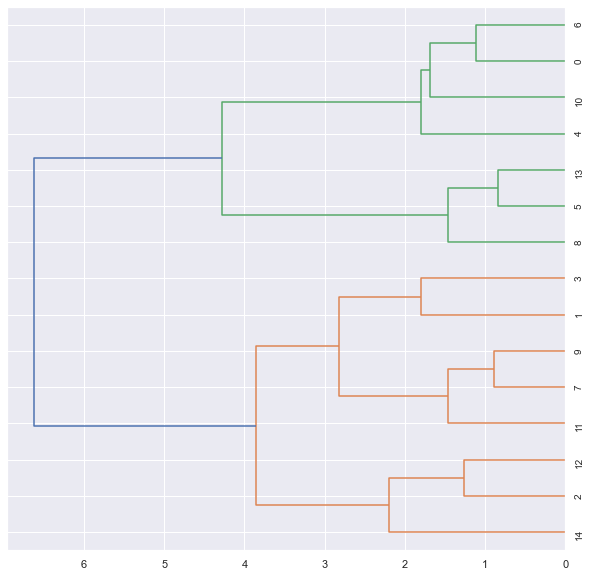

In [65]:
# get labels and centroids from the model
kp1_labels = kp_model1.labels_
kp1_centroids = kp_model1.cluster_centroids_

# what type of method to use for linkage???????????
ward_linkage = hierarchy.linkage(kp1_centroids, method = "ward")

# dendrogram
plt.subplots(figsize=(10,10))
hierarchy.dendrogram(ward_linkage,
                     orientation ="left" ,
                     leaf_rotation=90.,
                     leaf_font_size=10.,
                     show_contracted=True,
                     show_leaf_counts=True);

In [66]:
df_sociodem["Cluster"] = kp1_labels

In [67]:
cluster0 = df_sociodem[(df_sociodem.Cluster == 6)
                       | (df_sociodem.Cluster == 0)
                       | (df_sociodem.Cluster == 10)
                       | (df_sociodem.Cluster == 4)]
cluster0["Cluster"] = 0

cluster1 = df_sociodem[(df_sociodem.Cluster == 13)
                       | (df_sociodem.Cluster == 5)
                       | (df_sociodem.Cluster == 8)]
cluster1["Cluster"] = 1

cluster2 = df_sociodem[(df_sociodem.Cluster == 1)
                       | (df_sociodem.Cluster == 9)
                       | (df_sociodem.Cluster == 7)
                       | (df_sociodem.Cluster == 11)]
cluster2["Cluster"] = 2

cluster3 = df_sociodem[(df_sociodem.Cluster == 3)
                       | (df_sociodem.Cluster == 12)
                       | (df_sociodem.Cluster == 2)
                       | (df_sociodem.Cluster == 14)]
cluster3["Cluster"] = 3

kp1_sociodem_clusters = pd.concat([cluster0, cluster1, cluster2, cluster3], axis=0)

In [68]:
# let's take a quick look at the numbers for each cluster
print("Mean features values for each cluster:")
kp1_sociodem_clusters.groupby("Cluster").mean()

Mean features values for each cluster:


Age  Generation       YearSal   EducDeg  Children
Cluster                                                         
0        36.399568    3.420086  19669.925846  1.654068  0.865371
1        35.971654    3.441914  20496.502309  3.117100  0.918680
2        55.322859    2.279006  34824.811321  2.783494  0.873619
3        70.469414    1.490229  44995.833504  2.507647  0.122770

In [69]:
# what about children?
print("\nNumber of people with and without children in each cluster:")
kp1_sociodem_clusters.groupby("Cluster").Children.value_counts().sort_index()


Number of people with and without children in each cluster:


Cluster  Children
0        0.0          374
         1.0         2404
1        0.0          175
         1.0         1977
2        0.0          366
         1.0         2530
3        0.0         2065
         1.0          289
Name: Children, dtype: int64

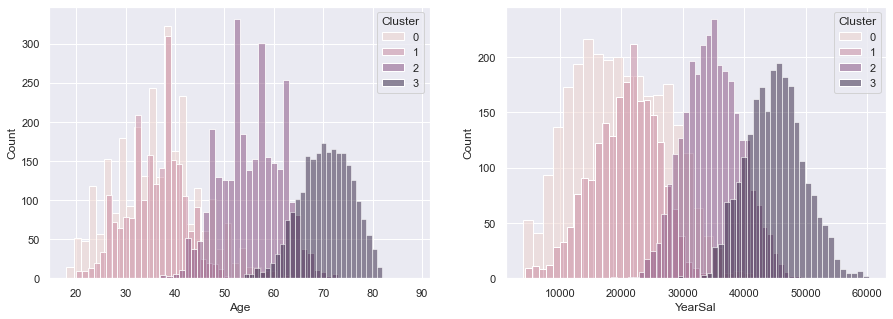

In [70]:
# represent the continuous features, Age and YearSal, for all three clusters as a histogram
metric_sociodem_feats = ["Age", "YearSal"]
other_sociodem_feats = ["Children", "EducDeg"]
n_clusters = np.arange(kp1_sociodem_clusters.Cluster.max()+1)

sns.set()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, feat in zip(axes.flatten(), metric_sociodem_feats):
    for n in n_clusters:
        cluster_feat = kp1_sociodem_clusters[kp1_sociodem_clusters.Cluster == n][feat]
        sns.histplot(data = kp1_sociodem_clusters, x = cluster_feat, ax = ax, hue = "Cluster")
        
plt.show()

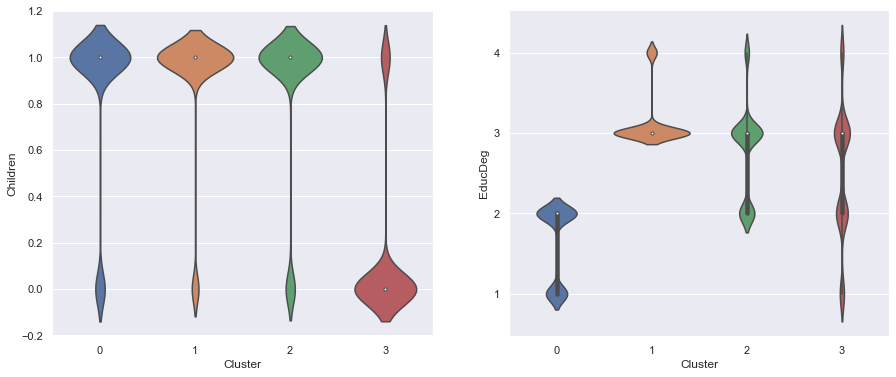

In [71]:
sns.set()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for ax, feat in zip(axes.flatten(), other_sociodem_feats):
    sns.violinplot(data = kp1_sociodem_clusters, x = "Cluster", y = feat, ax = ax)
    ax.set_xticks(np.arange(0, kp1_sociodem_clusters.Cluster.max()+1))
    
axes[1].set_yticks(np.arange(1, kp1_sociodem_clusters.EducDeg.max()+1));

In [144]:
test_kp1 = df.copy()
test_kp1["Cluster"] = kp1_sociodem_clusters["Cluster"]
test_kp1.groupby("Cluster").mean()

# CLUSTERS
# 0 - middle-aged adults, most with children, with low salary and low education
# 1 - middle-aged adults, most with children, with low salary and high education
# 2 - older adults, most with children, with medium salary
# 3 - elderly, most without children, with high salary

Generation        Age   EducDeg  Children       YearSal  CustYears  \
Cluster                                                                       
0          3.420086  36.399568  1.654068  0.865371  19669.925846  25.845932   
1          3.441914  35.971654  3.117100  0.918680  20496.502309  27.975836   
2          2.279006  55.322859  2.783494  0.873619  34824.811321  30.053522   
3          1.490229  70.469414  2.507647  0.122770  44995.833504  29.629992   

         CustMonVal   PremMotor  PremHousehold  PremHealth  PremLife  \
Cluster                                                                
0        238.599708  215.785749      18.679390   12.936722  7.939259   
1        209.117551  323.833485      13.976404   13.049698  5.424195   
2        220.778816  387.673353      13.266655   10.889764  5.117682   
3        196.096712  256.479703      15.980214   14.223166  6.504236   

         PremWork  PremTotal  
Cluster                       
0        8.151447  28.861448  
1        5.937387  26.451045  
2        5.632775  26.133250  
3        6.810593  27.350139

____________
KP2 - Generation, YearSal, EducDeg, Children

In [72]:
# return df_sociodem to original version
df_sociodem.drop(columns = "Cluster", inplace = True)
df_sociodem

Age  Generation  YearSal  EducDeg  Children
CustID                                              
1       34.0         4.0  26124.0      2.0       1.0
2       35.0         4.0   8124.0      2.0       1.0
3       46.0         3.0  27324.0      1.0       0.0
4       35.0         4.0  13188.0      3.0       1.0
5       43.0         3.0  21156.0      3.0       1.0
...      ...         ...      ...      ...       ...
10292   67.0         2.0  38256.0      4.0       0.0
10293   64.0         2.0  29172.0      1.0       0.0
10294   40.0         3.0  35016.0      3.0       1.0
10295   39.0         3.0  23652.0      1.0       1.0
10296   35.0         4.0  33780.0      4.0       1.0

[10180 rows x 5 columns]

In [73]:
# scaled dataframe to use with KPrototypes
df_sociodem_kp2 = pd.concat([df_scaled[["Generation", "YearSal", "EducDeg"]], df_sociodem[ "Children"]], axis=1)
df_sociodem_kp2

Generation   YearSal   EducDeg  Children
CustID                                          
1         1.412366 -0.329773 -0.607373       1.0
2         1.412366 -1.856416 -0.607373       1.0
3         0.363192 -0.227997 -1.867420       0.0
4         1.412366 -1.426920  0.652675       1.0
5         0.363192 -0.751127  0.652675       1.0
...            ...       ...       ...       ...
10292    -0.685983  0.699184  1.912723       0.0
10293    -0.685983 -0.071262 -1.867420       0.0
10294     0.363192  0.424388  0.652675       1.0
10295     0.363192 -0.539432 -1.867420       1.0
10296     1.412366  0.319559  1.912723       1.0

[10180 rows x 4 columns]

In [74]:
# KPrototypes to make cluster predictions
kp_model2 = KPrototypes(n_clusters = 15, init = "Huang", random_state = 15)
kp_model2.fit_predict(df_sociodem_kp2, categorical = [3])

array([10, 10, 14, ..., 11, 14,  0], dtype=uint16)

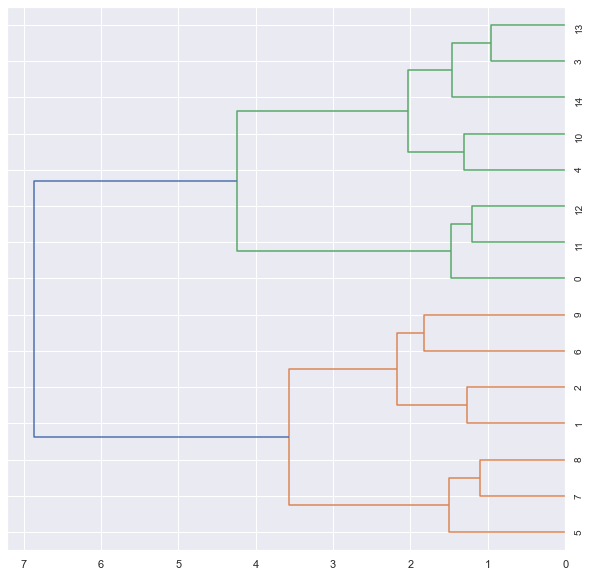

In [75]:
# get labels and centroids from the model
kp2_labels = kp_model2.labels_
kp2_centroids = kp_model2.cluster_centroids_

# calculate linkage
ward_linkage = hierarchy.linkage(kp2_centroids, method = "ward")

# visualise dendrogram
plt.subplots(figsize=(10,10))
hierarchy.dendrogram(ward_linkage,
                     orientation ="left" ,
                     leaf_rotation=90.,
                     leaf_font_size=10.,
                     show_contracted=True,
                     show_leaf_counts=True);

In [76]:
df_sociodem["Cluster"] = kp2_labels

In [77]:
cluster0 = df_sociodem[(df_sociodem.Cluster == 13)
                       | (df_sociodem.Cluster == 3)
                       | (df_sociodem.Cluster == 14)
                       | (df_sociodem.Cluster == 10)
                       | (df_sociodem.Cluster == 4)]
cluster0["Cluster"] = 0

cluster1 = df_sociodem[(df_sociodem.Cluster == 12)
                       | (df_sociodem.Cluster == 11)
                       | (df_sociodem.Cluster == 0)]
cluster1["Cluster"] = 1

cluster2 = df_sociodem[(df_sociodem.Cluster == 9)
                       | (df_sociodem.Cluster == 6)
                       | (df_sociodem.Cluster == 2)
                       | (df_sociodem.Cluster == 1)]
cluster2["Cluster"] = 2

cluster3 = df_sociodem[(df_sociodem.Cluster == 8)
                       | (df_sociodem.Cluster == 7)
                       | (df_sociodem.Cluster == 5)]
cluster3["Cluster"] = 3

kp2_sociodem_clusters = pd.concat([cluster0, cluster1, cluster2, cluster3], axis=0)
kp2_sociodem_clusters.Generation.replace(gen_mapper, inplace = True)

In [78]:
# let's take a quick look at the numbers for each cluster
print("Mean features values for each cluster:")
kp2_sociodem_clusters.groupby("Cluster").mean()

Mean features values for each cluster:


Age       YearSal   EducDeg  Children
Cluster                                             
0        36.541359  20034.943330  1.681098  0.866244
1        38.639444  22902.586651  3.119116  0.916191
2        63.018007  39493.482016  2.903962  0.578932
3        68.573566  43885.256507  1.719867  0.200333

In [79]:
# what about children?
print("\nNumber of people with and without children in each cluster:")
kp2_sociodem_clusters.groupby("Cluster").Children.value_counts().sort_index()


Number of people with and without children in each cluster:


Cluster  Children
0        0.0          380
         1.0         2461
1        0.0          235
         1.0         2569
2        0.0         1403
         1.0         1929
3        0.0          962
         1.0          241
Name: Children, dtype: int64

In [80]:
# people per generation
kp2_sociodem_clusters.groupby("Cluster").Generation.value_counts().sort_index()

Cluster  Generation 
0        Baby Boomer      39
         Gen X          1557
         Gen Z            33
         Millennial     1212
1        Baby Boomer      11
         Gen X          1843
         Gen Z             1
         Millennial      949
2        Baby Boomer    2604
         Gen X            39
         Silent Gen      689
3        Baby Boomer     681
         Gen X             2
         Silent Gen      520
Name: Generation, dtype: int64

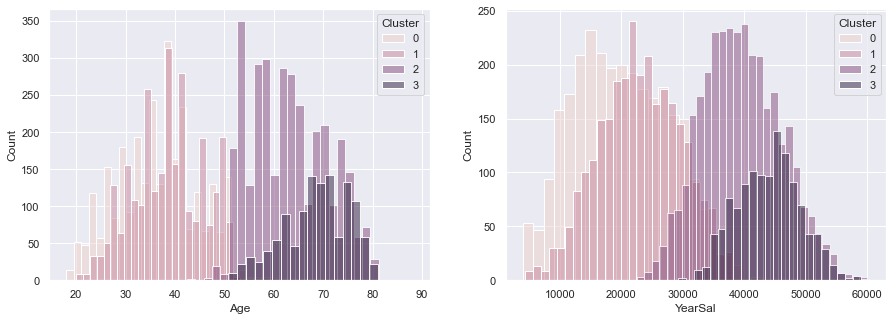

In [110]:
# represent the continuous features, Age and YearSal, for all three clusters as a histogram
metric_sociodem_feats = ["Age", "YearSal"]
other_sociodem_feats = ["Generation", "Children", "EducDeg"]
n_clusters = np.arange(kp2_sociodem_clusters.Cluster.max()+1)

sns.set()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, feat in zip(axes.flatten(), metric_sociodem_feats):
    for n in n_clusters:
        cluster_feat = kp2_sociodem_clusters[kp2_sociodem_clusters.Cluster == n][feat]
        sns.histplot(data = kp2_sociodem_clusters, x = cluster_feat, ax = ax, hue = "Cluster")
        
plt.show()

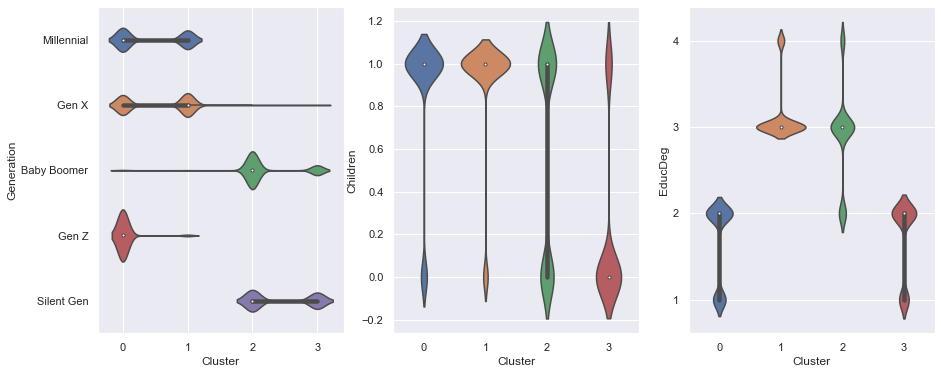

In [111]:
sns.set()

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for ax, feat in zip(axes.flatten(), other_sociodem_feats):
    sns.violinplot(data = kp2_sociodem_clusters, x = "Cluster", y = feat, ax = ax)
    ax.set_xticks(np.arange(0, kp2_sociodem_clusters.Cluster.max()+1))
    
axes[2].set_yticks(np.arange(1, kp2_sociodem_clusters.EducDeg.max()+1));

In [145]:
test_kp2 = df.copy()
test_kp2["Cluster"] = kp2_sociodem_clusters["Cluster"]
test_kp2.groupby("Cluster").mean()

# CLUSTERS
# 0 - middle-aged adults, most with children, with low salary and low education
# 1 - middle-aged adults, most with children, with low salary and high education
# 2 - elderly, with high salary and high education
# 3 - elderly, most without children, with high salary and low education

Generation        Age   EducDeg  Children       YearSal  CustYears  \
Cluster                                                                       
0          3.436114  36.541359  1.681098  0.866244  20034.943330  25.920451   
1          3.335235  38.639444  3.119116  0.916191  22902.586651  28.461840   
2          1.804922  63.018007  2.903962  0.578932  39493.482016  29.908764   
3          1.569410  68.573566  1.719867  0.200333  43885.256507  29.663342   

         CustMonVal   PremMotor  PremHousehold  PremHealth  PremLife  \
Cluster                                                                
0        235.523270  223.322527      18.442690   12.825042  7.816504   
1        210.375920  355.506733      13.258322   12.190722  5.062936   
2        207.960870  338.112620      13.988056   12.501120  5.524350   
3        217.703042  220.204730      18.142979   13.937482  7.522536   

         PremWork  PremTotal  
Cluster                       
0        8.036375  28.743138  
1        5.600684  26.138725  
2        5.974014  26.410834  
3        7.751916  28.437848

## Agglomerative clustering

In [112]:
#df_sociodem.drop(columns = "Cluster", inplace = True)
df_sociodem

Age  Generation  YearSal  EducDeg  Children  Cluster
CustID                                                       
1       34.0         4.0  26124.0      2.0       1.0       10
2       35.0         4.0   8124.0      2.0       1.0       10
3       46.0         3.0  27324.0      1.0       0.0       14
4       35.0         4.0  13188.0      3.0       1.0       12
5       43.0         3.0  21156.0      3.0       1.0       11
...      ...         ...      ...      ...       ...      ...
10292   67.0         2.0  38256.0      4.0       0.0        9
10293   64.0         2.0  29172.0      1.0       0.0        5
10294   40.0         3.0  35016.0      3.0       1.0       11
10295   39.0         3.0  23652.0      1.0       1.0       14
10296   35.0         4.0  33780.0      4.0       1.0        0

[10180 rows x 6 columns]

In [165]:
#df_sociodem_ac1 = pd.concat([df_scaled[["Generation", "YearSal", "EducDeg"]], df["Children"]], axis=1)
df_sociodem_ac1 = df_scaled[["Generation", "YearSal", "EducDeg", "Children"]]
df_sociodem_ac1

Generation   YearSal   EducDeg  Children
CustID                                          
1         1.412366 -0.329773 -0.607373  0.643342
2         1.412366 -1.856416 -0.607373  0.643342
3         0.363192 -0.227997 -1.867420 -1.554383
4         1.412366 -1.426920  0.652675  0.643342
5         0.363192 -0.751127  0.652675  0.643342
...            ...       ...       ...       ...
10292    -0.685983  0.699184  1.912723 -1.554383
10293    -0.685983 -0.071262 -1.867420 -1.554383
10294     0.363192  0.424388  0.652675  0.643342
10295     0.363192 -0.539432 -1.867420  0.643342
10296     1.412366  0.319559  1.912723  0.643342

[10180 rows x 4 columns]

In [166]:
ac_model1 = AgglomerativeClustering(n_clusters = 4, affinity = "euclidean", linkage = "ward").fit(df_sociodem_ac1)
ac1_sociodem_clusters = df_sociodem.copy()
ac1_sociodem_clusters["Cluster"] = ac_model1.labels_
ac1_sociodem_clusters.Generation.replace(gen_mapper, inplace = True)
ac1_sociodem_clusters

Age   Generation  YearSal  EducDeg  Children  Cluster
CustID                                                        
1       34.0   Millennial  26124.0      2.0       1.0        3
2       35.0   Millennial   8124.0      2.0       1.0        3
3       46.0        Gen X  27324.0      1.0       0.0        0
4       35.0   Millennial  13188.0      3.0       1.0        3
5       43.0        Gen X  21156.0      3.0       1.0        3
...      ...          ...      ...      ...       ...      ...
10292   67.0  Baby Boomer  38256.0      4.0       0.0        1
10293   64.0  Baby Boomer  29172.0      1.0       0.0        1
10294   40.0        Gen X  35016.0      3.0       1.0        3
10295   39.0        Gen X  23652.0      1.0       1.0        0
10296   35.0   Millennial  33780.0      4.0       1.0        3

[10180 rows x 6 columns]

In [167]:
ac1_sociodem_clusters.groupby("Cluster").mean()

Age       YearSal   EducDeg  Children
Cluster                                             
0        38.245370  20992.474019  1.745370   0.74032
1        69.328819  43693.684329  2.561574   0.00000
2        59.333333  37095.855839  2.580009   1.00000
3        36.971779  21930.066472  2.895706   1.00000

In [168]:
ac1_sociodem_clusters.groupby("Cluster").Children.value_counts().sort_index()

Cluster  Children
0        0.0          617
         1.0         1759
1        0.0         2363
2        1.0         2181
3        1.0         3260
Name: Children, dtype: int64

In [169]:
ac1_sociodem_clusters.groupby("Cluster").Generation.value_counts().sort_index()

Cluster  Generation 
0        Gen X          1714
         Gen Z            29
         Millennial      633
1        Baby Boomer    1286
         Silent Gen     1077
2        Baby Boomer    2049
         Silent Gen      132
3        Gen X          1727
         Gen Z             5
         Millennial     1528
Name: Generation, dtype: int64

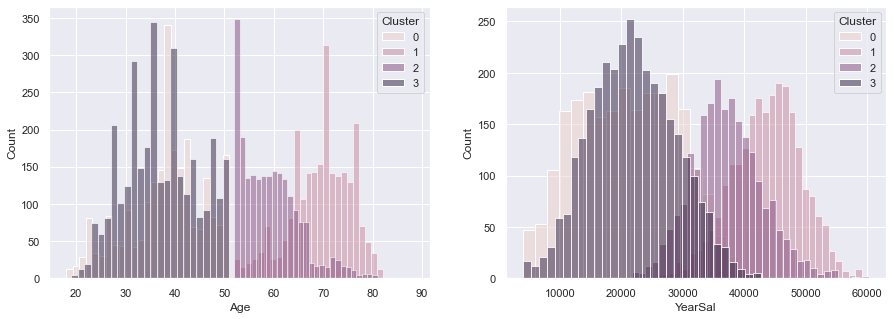

In [170]:
# represent the continuous features, Age and YearSal, for all three clusters as a histogram
metric_sociodem_feats = ["Age", "YearSal"]
other_sociodem_feats = ["Children", "EducDeg", "Generation"]
n_clusters = np.arange(ac1_sociodem_clusters.Cluster.max()+1)

sns.set()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, feat in zip(axes.flatten(), metric_sociodem_feats):
    for n in n_clusters:
        cluster_feat = ac1_sociodem_clusters[ac1_sociodem_clusters.Cluster == n][feat]
        sns.histplot(data = ac1_sociodem_clusters, x = cluster_feat, ax = ax, hue = "Cluster")
        
plt.show()

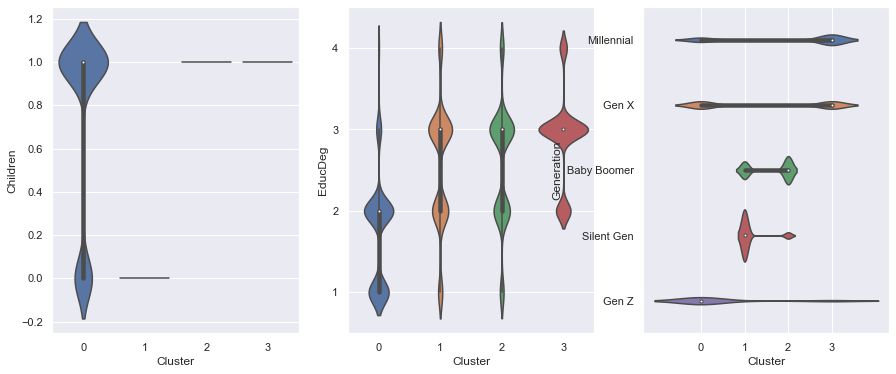

In [171]:
sns.set()

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for ax, feat in zip(axes.flatten(), other_sociodem_feats):
    sns.violinplot(data = ac1_sociodem_clusters, x = "Cluster", y = feat, ax = ax)
    ax.set_xticks(np.arange(0, ac1_sociodem_clusters.Cluster.max()+1))
    
axes[1].set_yticks(np.arange(1, ac1_sociodem_clusters.EducDeg.max()+1));

In [172]:
test_ac1 = df.copy()
test_ac1["Cluster"] = ac1_sociodem_clusters["Cluster"]
test_ac1.groupby("Cluster").mean()

# CLUSTERS
# 0 - middle-aged adults, most with children, low salary, low education
# 1 - elderly, no children, high salary
# 2 - older adults, with hildren, high salary
# 3 - middle-aged adults, with children, low salary, high education

Generation        Age   EducDeg  Children       YearSal  CustYears  \
Cluster                                                                       
0          3.290825  38.245370  1.745370   0.74032  20992.474019  26.531987   
1          1.544223  69.328819  2.561574   0.00000  43693.684329  29.759204   
2          1.939477  59.333333  2.580009   1.00000  37095.855839  29.924347   
3          3.471779  36.971779  2.895706   1.00000  21930.066472  27.657055   

         CustMonVal   PremMotor  PremHousehold  PremHealth  PremLife  \
Cluster                                                                
0        241.061498  242.619175      18.010521   12.385195  7.593770   
1        201.796614  255.329281      15.973835   14.297009  6.509225   
2        218.865213  360.605392      14.208709   11.377024  5.610691   
3        210.701080  324.083163      14.257012   12.581260  5.582483   

         PremWork  PremTotal  
Cluster                       
0        7.825130  28.544569  
1        6.766213  27.347042  
2        6.131748  26.546349  
3        6.077368  26.632922

## KMeans

KM1 - Age, YearSal, EducDeg, Children

In [91]:
df_sociodem

Age  Generation  YearSal  EducDeg  Children  Cluster
CustID                                                       
1       34.0         4.0  26124.0      2.0       1.0       10
2       35.0         4.0   8124.0      2.0       1.0       10
3       46.0         3.0  27324.0      1.0       0.0       14
4       35.0         4.0  13188.0      3.0       1.0       12
5       43.0         3.0  21156.0      3.0       1.0       11
...      ...         ...      ...      ...       ...      ...
10292   67.0         2.0  38256.0      4.0       0.0        9
10293   64.0         2.0  29172.0      1.0       0.0        5
10294   40.0         3.0  35016.0      3.0       1.0       11
10295   39.0         3.0  23652.0      1.0       1.0       14
10296   35.0         4.0  33780.0      4.0       1.0        0

[10180 rows x 6 columns]

In [92]:
#df_sociodem_km1 = pd.concat([df_scaled[["Age", "YearSal", "EducDeg"]], df["Children"]], axis=1)
df_sociodem_km1 = df_scaled[["Age", "YearSal", "EducDeg", "Children"]]
df_sociodem_km1

Age   YearSal   EducDeg  Children
CustID                                        
1      -1.007168 -0.329773 -0.607373  0.643342
2      -0.942484 -1.856416 -0.607373  0.643342
3      -0.230962 -0.227997 -1.867420 -1.554383
4      -0.942484 -1.426920  0.652675  0.643342
5      -0.425014 -0.751127  0.652675  0.643342
...          ...       ...       ...       ...
10292   1.127399  0.699184  1.912723 -1.554383
10293   0.933347 -0.071262 -1.867420 -1.554383
10294  -0.619065  0.424388  0.652675  0.643342
10295  -0.683749 -0.539432 -1.867420  0.643342
10296  -0.942484  0.319559  1.912723  0.643342

[10180 rows x 4 columns]

In [93]:
km_model1 = KMeans(n_clusters = 4, random_state = 15).fit(df_sociodem_km1)
km1_sociodem_clusters = df_sociodem.copy()
km1_sociodem_clusters["Cluster"] = km_model1.labels_
km1_sociodem_clusters.Generation.replace(gen_mapper, inplace = True)
km1_sociodem_clusters["Cluster"] = km_model1.labels_
km1_sociodem_clusters

Age   Generation  YearSal  EducDeg  Children  Cluster
CustID                                                        
1       34.0   Millennial  26124.0      2.0       1.0        3
2       35.0   Millennial   8124.0      2.0       1.0        3
3       46.0        Gen X  27324.0      1.0       0.0        3
4       35.0   Millennial  13188.0      3.0       1.0        1
5       43.0        Gen X  21156.0      3.0       1.0        1
...      ...          ...      ...      ...       ...      ...
10292   67.0  Baby Boomer  38256.0      4.0       0.0        2
10293   64.0  Baby Boomer  29172.0      1.0       0.0        2
10294   40.0        Gen X  35016.0      3.0       1.0        1
10295   39.0        Gen X  23652.0      1.0       1.0        3
10296   35.0   Millennial  33780.0      4.0       1.0        1

[10180 rows x 6 columns]

In [94]:
km1_sociodem_clusters.groupby("Cluster").mean()

Age       YearSal   EducDeg  Children
Cluster                                             
0        57.099549  36539.025389  2.564613  1.000000
1        37.696563  21814.260359  3.152509  0.931648
2        68.482310  43194.249723  2.566490  0.000000
3        35.135285  18524.894779  1.641614  0.862342

In [95]:
km1_sociodem_clusters.groupby("Cluster").Children.value_counts().sort_index()

Cluster  Children
0        1.0         2662
1        0.0          173
         1.0         2358
2        0.0         2459
3        0.0          348
         1.0         2180
Name: Children, dtype: int64

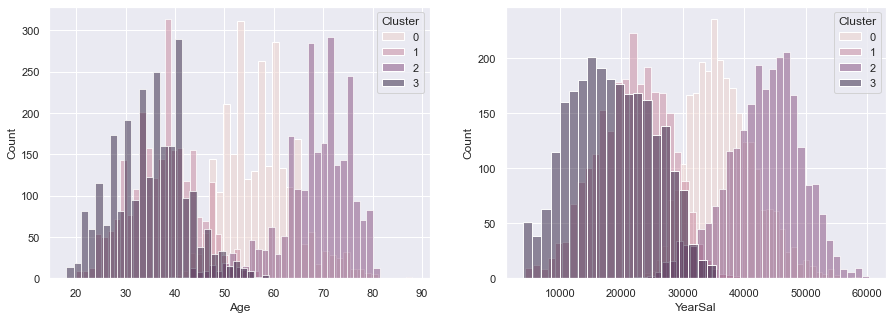

In [96]:
# represent the continuous features, Age and YearSal, for all three clusters as a histogram
metric_sociodem_feats = ["Age", "YearSal"]
other_sociodem_feats = ["Children", "EducDeg", "Generation"]
n_clusters = np.arange(ac1_sociodem_clusters.Cluster.max()+1)

sns.set()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, feat in zip(axes.flatten(), metric_sociodem_feats):
    for n in n_clusters:
        cluster_feat = km1_sociodem_clusters[km1_sociodem_clusters.Cluster == n][feat]
        sns.histplot(data = km1_sociodem_clusters, x = cluster_feat, ax = ax, hue = "Cluster")
        
plt.show()

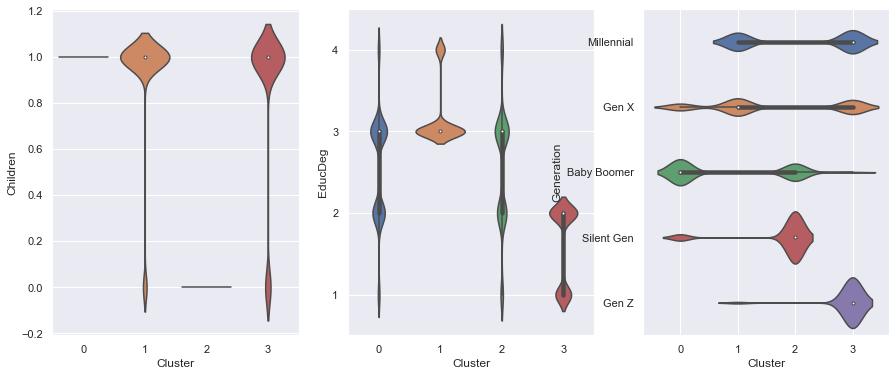

In [97]:
sns.set()

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for ax, feat in zip(axes.flatten(), other_sociodem_feats):
    sns.violinplot(data = km1_sociodem_clusters, x = "Cluster", y = feat, ax = ax)
    ax.set_xticks(np.arange(0, km1_sociodem_clusters.Cluster.max()+1))
    
axes[1].set_yticks(np.arange(1, km1_sociodem_clusters.EducDeg.max()+1));

In [154]:
test_km1 = df.copy()
test_km1["Cluster"] = km1_sociodem_clusters["Cluster"]
test_km1.groupby("Cluster").mean()

# CLUSTERS
# 0 - older adults, with children, high salary 
# 1 - middle-aged adults, with children, low salary, high education
# 2 - elderly, no children, high salary
# 3 - middle-aged adults, with children, low salary, low education

Generation        Age   EducDeg  Children       YearSal  CustYears  \
Cluster                                                                       
0          2.172051  57.099549  2.564613  1.000000  36539.025389  30.027047   
1          3.350849  37.696563  3.152509  0.931648  21814.260359  28.286843   
2          1.601464  68.482310  2.566490  0.000000  43194.249723  29.712485   
3          3.486946  35.135285  1.641614  0.862342  18524.894779  25.395174   

         CustMonVal   PremMotor  PremHousehold  PremHealth  PremLife  \
Cluster                                                                
0        214.871240  375.683426      13.698825   11.094315  5.335911   
1        211.870557  345.184425      13.449506   12.482162  5.175110   
2        201.442981  260.477609      15.894482   14.148720  6.466680   
3        241.399589  201.167809      19.151393   13.102109  8.170863   

         PremWork  PremTotal  
Cluster                       
0        5.891204  26.314254  
1        5.698503  26.227917  
2        6.734738  27.311364  
3        8.346762  29.103570

KM2 - Generation, YearSal, EducDeg, Children

In [98]:
df_sociodem

Age  Generation  YearSal  EducDeg  Children  Cluster
CustID                                                       
1       34.0         4.0  26124.0      2.0       1.0       10
2       35.0         4.0   8124.0      2.0       1.0       10
3       46.0         3.0  27324.0      1.0       0.0       14
4       35.0         4.0  13188.0      3.0       1.0       12
5       43.0         3.0  21156.0      3.0       1.0       11
...      ...         ...      ...      ...       ...      ...
10292   67.0         2.0  38256.0      4.0       0.0        9
10293   64.0         2.0  29172.0      1.0       0.0        5
10294   40.0         3.0  35016.0      3.0       1.0       11
10295   39.0         3.0  23652.0      1.0       1.0       14
10296   35.0         4.0  33780.0      4.0       1.0        0

[10180 rows x 6 columns]

In [99]:
#df_sociodem_km2 = pd.concat([df_scaled[["Generation", "YearSal", "EducDeg"]], df["Children"]], axis=1)
df_sociodem_km2 = df_scaled[["Generation", "YearSal", "EducDeg", "Children"]]
df_sociodem_km2

Generation   YearSal   EducDeg  Children
CustID                                          
1         1.412366 -0.329773 -0.607373  0.643342
2         1.412366 -1.856416 -0.607373  0.643342
3         0.363192 -0.227997 -1.867420 -1.554383
4         1.412366 -1.426920  0.652675  0.643342
5         0.363192 -0.751127  0.652675  0.643342
...            ...       ...       ...       ...
10292    -0.685983  0.699184  1.912723 -1.554383
10293    -0.685983 -0.071262 -1.867420 -1.554383
10294     0.363192  0.424388  0.652675  0.643342
10295     0.363192 -0.539432 -1.867420  0.643342
10296     1.412366  0.319559  1.912723  0.643342

[10180 rows x 4 columns]

In [100]:
km_model2 = KMeans(n_clusters = 4, random_state = 15).fit(df_sociodem_km2)
km2_sociodem_clusters = df_sociodem.copy()
km2_sociodem_clusters["Cluster"] = km_model2.labels_
km2_sociodem_clusters.Generation.replace(gen_mapper, inplace = True)
km2_sociodem_clusters["Cluster"] = km_model2.labels_
km2_sociodem_clusters

Age   Generation  YearSal  EducDeg  Children  Cluster
CustID                                                        
1       34.0   Millennial  26124.0      2.0       1.0        1
2       35.0   Millennial   8124.0      2.0       1.0        1
3       46.0        Gen X  27324.0      1.0       0.0        1
4       35.0   Millennial  13188.0      3.0       1.0        3
5       43.0        Gen X  21156.0      3.0       1.0        3
...      ...          ...      ...      ...       ...      ...
10292   67.0  Baby Boomer  38256.0      4.0       0.0        2
10293   64.0  Baby Boomer  29172.0      1.0       0.0        2
10294   40.0        Gen X  35016.0      3.0       1.0        3
10295   39.0        Gen X  23652.0      1.0       1.0        1
10296   35.0   Millennial  33780.0      4.0       1.0        3

[10180 rows x 6 columns]

In [101]:
km2_sociodem_clusters.groupby("Cluster").mean()

Age       YearSal   EducDeg  Children
Cluster                                             
0        58.331637  37134.797958  2.566158  1.000000
1        35.714016  19030.403476  1.660370  0.869286
2        68.335763  43134.243851  2.567031  0.000000
3        38.369180  22575.237609  3.134885  0.939024

In [102]:
km2_sociodem_clusters.groupby("Cluster").Children.value_counts().sort_index()

Cluster  Children
0        1.0         2358
1        0.0          346
         1.0         2301
2        0.0         2469
3        0.0          165
         1.0         2541
Name: Children, dtype: int64

In [103]:
km2_sociodem_clusters.groupby("Cluster").Generation.value_counts().sort_index()

Cluster  Generation 
0        Baby Boomer    2002
         Gen X           224
         Silent Gen      132
1        Baby Boomer      31
         Gen X          1371
         Gen Z            33
         Millennial     1212
2        Baby Boomer    1286
         Gen X           106
         Silent Gen     1077
3        Baby Boomer      16
         Gen X          1740
         Gen Z             1
         Millennial      949
Name: Generation, dtype: int64

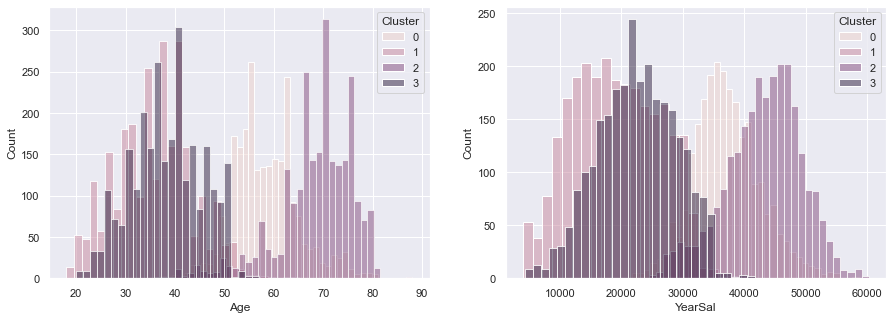

In [104]:
cont_sociodem_feats = ["Age", "YearSal"]
other_sociodem_feats = ["Children", "EducDeg", "Generation"]
n_clusters = np.arange(km2_sociodem_clusters.Cluster.max()+1)

sns.set()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, feat in zip(axes.flatten(), cont_sociodem_feats):
    for n in n_clusters:
        cluster_feat = km2_sociodem_clusters[km2_sociodem_clusters.Cluster == n][feat]
        sns.histplot(data = km2_sociodem_clusters, x = cluster_feat, ax = ax, hue = "Cluster")
        
plt.show()

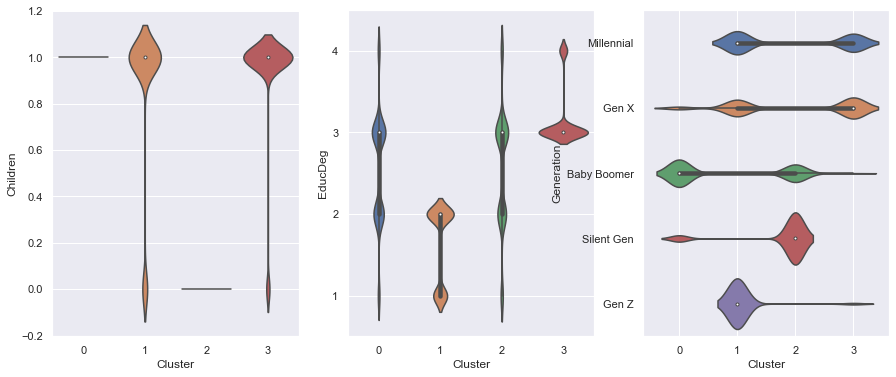

In [105]:
sns.set()

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for ax, feat in zip(axes.flatten(), other_sociodem_feats):
    sns.violinplot(data = km2_sociodem_clusters, x = "Cluster", y = feat, ax = ax)
    ax.set_xticks(np.arange(0, km2_sociodem_clusters.Cluster.max()+1))
    
axes[1].set_yticks(np.arange(1, km2_sociodem_clusters.EducDeg.max()+1));

In [155]:
test_km2 = df.copy()
test_km2["Cluster"] = km2_sociodem_clusters["Cluster"]
test_km2.groupby("Cluster").mean()

# CLUSTERS
# 0 - older adults, with children, high salary, average education
# 1 - middle-aged adults, with children, low salary, high education
# 2 - elderly, no children, high salary, average education
# 3 - middle-aged adults, with children, low salary, low education

Generation        Age   EducDeg  Children       YearSal  CustYears  \
Cluster                                                                       
0          2.039016  58.331637  2.566158  1.000000  37134.797958  29.993639   
1          3.471099  35.714016  1.660370  0.869286  19030.403476  25.622214   
2          1.606723  68.335763  2.567031  0.000000  43134.243851  29.733900   
3          3.345528  38.369180  3.134885  0.939024  22575.237609  28.391722   

         CustMonVal   PremMotor  PremHousehold  PremHealth  PremLife  \
Cluster                                                                
0        216.525628  366.105670      14.053615   11.289290  5.502619   
1        240.330397  210.724114      18.815541   12.986511  8.016940   
2        201.264382  260.313836      15.912548   14.145116  6.474828   
3        210.714826  354.404642      13.220615   12.239291  5.054524   

         PremWork  PremTotal  
Cluster                       
0        6.044343  26.470967  
1        8.209443  28.935975  
2        6.736515  27.320050  
3        5.599120  26.126608